# Premise

There may be factors embedded in the language of screenplays that determine whether a given movie might be a highly rated or lowlyl rated film upon its release. The purpose of this project is to uncover those factors using natural language processing and create a classification model to determine if it can be predicted whether  or not a film will be well-rated based upon its screenplay.

As I am in the process of creating this report, I will also perform some clustering work on the screenplays to find out if there are any interesting ways in which they can be categorized based upon their language, rather than merely on their genre.

# Imports and Functions

## Imports

In [3227]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import statsmodels.api as sm
import plotly.offline as pyo
import plotly.express as px
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import numpy as np
import requests
import random
import spacy
import time
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.plotting import plot_confusion_matrix
from tqdm._tqdm_notebook import tqdm_notebook
from pydotplus import graph_from_dot_data
from pandas.plotting import scatter_matrix
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer
from statsmodels.formula.api import ols
from nltk import word_tokenize
from IPython.display import Image 
from functools import reduce
from gensim.models import Word2Vec
from bs4 import BeautifulSoup
from ast import literal_eval
from tqdm import tqdm

np.random.seed(42)

%matplotlib inline

In [2]:
tqdm_notebook.pandas()

In [3]:
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

## Format Titles

This function formats the titles to use in the urls when scraping the screenplays

In [1071]:
def format_titles(title_list):
    """This function formats the movie titles in such a way that they can be
    discerned by the web site where the screenplays will be taken from.
    
    Parameter:
    
        title_list: list
        list of titles to be formatted, generally from metacritic.
        
    Returns: 
    
        list containing titles in the proper format for scraping screenplays from
        springfieldspringfield.co.uk."""
    
    # Initializing list for later
    titles_formatted = []
    
    # Will cycle through all titles and leave them in the correct format for
    # later use.
    for title in title_list:
        title = title.lower()
        
        # Titles on this site have ', the' at the end.
        if title[:3] == 'the':
            title = title[4:] + ', the'
        
        # Getting rid of punctuation that wouldn't be in the url.
        punctuations = """!()-[]{};:'"\,<>./?@#$%^&*~"""
        for x in title: 
            if x in punctuations: 
                title = title.replace(x, '')
        
        # In the url, the spaces are hyphens.
        for x in title:
            title = title.replace('  ', '-')
            title = title.replace(' ', '-')
            title = title.replace('_', '-')
            
        titles_formatted.append(title)

    return titles_formatted

## Grab Screenplays

This function scrapes the needed screenplays from an Internet site.

In [ ]:
def grab_screenplays(formatted_titles):
    """Function takes correctly formatted titles and scrapes the associated
    screenplays from http://www.springfieldspringfield.co.uk.
    
    Parameter:
    
        formatted_titles: list
            Takes titles formatted by the fomatted_titles function and 
            retrieves screenplays from springfieldspringfield.
 
     Returns:
         
         list containing screenplays from argument title list.
         
         list conaining list of movies for which screenplays could not be
         found."""
         
    # scrs will hold the screenplays themselves. errors will house the titles
    # of the movies we couldn't retrieve scripts for.
    scrs = {}
    errors = []
    
    for title in formatted_titles:
        print(title)
        
        # Beginning the web scraping by opening the connection to the site,
        # putting the title into the url, and and copying the html into local variables.
        # Note the titles are pre-formatted as word-word-word-the (if there is a 'the.'
        html_page = requests.get(
            'https://www.springfieldspringfield.co.uk/movie_script.php?movie={}'.format(title))
        soup = BeautifulSoup(html_page.content, 'html.parser')
        
        # Getting the container for the screenplay.
        scr = soup.find('div', class_ = 'scrolling-script-container')
        
        # Several conditionals here to cycle through the various possibilities
        # of title formatting to find if there is a page at all.
        if scr:
            scr = scr.contents
        if not scr:
            
            # The formatting function puts 'the' at the end if there is one. 
            # Sometimes 'the' is simply removed. This will catch those.
            no_the = title[:-4]
            html_page = requests.get(
                'https://www.springfieldspringfield.co.uk/movie_script.php?movie={}'.format(no_the))
            soup = BeautifulSoup(html_page.content, 'html.parser')
            scr = soup.find('div', class_ = 'scrolling-script-container')
            if scr:
                scr = scr.contents
                
            
        if not scr:
            
            # A few movies keep 'the' at the beginning. This will catch those.
            pre_the = 'the-' + title[:-4]
            html_page = requests.get(
                'https://www.springfieldspringfield.co.uk/movie_script.php?movie={}'.format(pre_the))
            soup = BeautifulSoup(html_page.content, 'html.parser')
            scr = soup.find('div', class_ = 'scrolling-script-container')
            if scr:
                scr = scr.contents
                
            # If we still can't find the script, return a message that we couldn't
            # and put the title in an error list.
        if not scr:
            print('***The following screenplay could not be retrieved: ', title)
            errors.append(title)
        if scr:
            
            # Pulling out the unnecessary line html line breaks.
            scr = [i for i in scr if str(i) not in ['<br/>']] 
        scrs[title] = scr
        
        # Sleeping between each loop so the site server doesn't think we're 
        # trying to do anything malicious.
        time.sleep(1)
        
    return scrs, errors

## Clean

The scripts at this point are broken up into words but with extra punctuation and symbols we don't want. This function combines each script into into one long string, then cleans the punctuations and html out of the screenplays, though in some cases they wind up being tokenized later.

In [6]:
def clean(word_list):
    """Combines each script into one long string and removes punctuation and
    html tags from the scripts. Note that this function is not always used,
    depending on what is needed from the data.
    
    Parameters:
    
        word_list: list
            List of words from one screenplay, usually in raw format
            
    Returns:
    
        A complete screenplay made of one long string with symbols and html
        breaks removed."""
    
    result = ''
    
    # Each line of the scipt is broken into a separate string. This combines
    # them into one long string.
    for line in word_list:
        result += str(line)
        
    # This removes the line breaks. They should have already been removed 
    # above but this is a backup.
    while '<br/>' in result:
        result = result.replace('<br/>', '')
        
    # Removing punctuations.
    punctuations = """!()-[]{};:"\,<>./?@#$%^&*_~"""
    for char in result: 
        if char in punctuations: 
            result = result.replace(char, '')
    
    return result

## Script Classifiers

The main function for using conventional classifiers

In [922]:
def script_classifiers(X, y, classifier, cmap=plt.cm.Reds, use_tfidf=True):
    """This function takes in values for a classifier and runs them through
    a pipe. Generates scores and a confusion matrix plot.
    
    Parameters:
        
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model."""
    
    # Typical train test split to retain data for validation.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=42)
    
    # There a few more bad scripts than good ones, so I'll make them even.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)
    
    # This is necessary for putting X into the correct format if there is only 
    # one column, as it comes out of the resampler a DataFrame when the
    # classifier actuallyl wants a series if its only one column.
    if len(X_resampled.columns) < 2:
        X_resampled = X_resampled.iloc[:, 0]
    
    # Provides the option of using tfidf in case this is just using scripts 
    # attributes and not text embedding or vectorization
    if use_tfidf == False:
        pipe = Pipeline([('clf', classifier)])
    else:
        
        # These tfidf hyper-parameters have been tested via grid-search
        # elsewhere and found to be optimal.
        pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=.95, min_df=.1,
                                                  max_features=5000,
                                                  ngram_range=(1,2))), 
                         ('clf', classifier)])
        
#     scaler = StandardScaler
#     X_resampled_scaled = scaler.fit_transform(X_resampled)
#     X_test_scaled = scaler.transform(X_test)
    
    # Fitting the pipeline containing the tfidf processor and classifier.
    pipe.fit(X_resampled, y_resampled)
    
    # Creating predicted data.
    y_pred = pipe.predict(X_test)
    
    # Running metrics and creating a confusion matrix visual.
    print(classification_report(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)
    
    plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                      show_normed=True, cmap=cmap);
    plt.show();
    
    # If there is a decision function in this classifier, we'll use it 
    # to create an ROC AUC graph.
    try:
        y_score = pipe.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        print('roc_auc score: ', roc_auc)

        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show();
    except:
        pass
    
#     # Creating a decision tree classifier tree graph because it's cool.
# #     if classifier == DecisionTreeClassifier():
#     dot_data = export_graphviz(classifier, out_file=None, 
# #                                    feature_names=X.columns, 
#                                class_names=np.unique(y).astype('str'), 
#                                filled=True, rounded=True, 
#                                special_characters=True)

#     # Draw graph
#     graph = graph_from_dot_data(dot_data)  
#     # Show graph
#     Image(graph.create_png()) 
#     return Image(graph.create_png()) 

## Pipeless Classifier

In [955]:
def ceci_nest_pas_une_pipe(X, y, text_to_vec, classifier, 
                           cmap=plt.cm.Reds):
    """This function takes in values for a classifier and runs them through
    a pipe. Generates scores and a confusion matrix plot. As opposed with 
    the above 'script_classifiers' function, this one does not use a pipe,
    lending some additional flexibility between vectorization and modeling.
    Generally to be used with combining features and word vectors.
    
    Parameters:
        
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        text_to_vec: word vector matrix
            In addition to features, adds a word vector matrix to join with
            the other features for modeling.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot."""

#     if text_to_vec:
    # Putting the TfidfVectorizer up front so I can fiddle with things
    # before the classifier.
    tfidf = TfidfVectorizer(max_df=.95, min_df=.1, max_features=5000,
                             ngram_range=(1,2))
    X2 = tfidf.fit_transform(text_to_vec)

    # Creating a sparse DataFrame to house both the features and the 
    # processed text.
    X_temp = pd.SparseDataFrame(X2, columns=tfidf.get_feature_names(),
                               default_fill_value=0)

    # Necessary for next step.
    X = X.reset_index(drop=True)

    # Combining text matrix with script attributes.
    for column in X:
        X_temp[column] = X[column]
    X = X_temp
    
    # Standard train-test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=42)
    
    # There a few more bad scripts than good ones, so I'll make them even.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)
   
    # This is necessary for putting X into the correct format if there is only 
    # one column, as it comes out of the resampler a DataFrame when the
    # classifier actuallyl wants a series if its only one column.
    if type(X_resampled) == pd.core.series.Series:
        X_resampled = X_resampled.iloc[:, 0]
    
    # Classifier can be whatever the user has entered as an argument. 
    clf = classifier
    clf.fit(X_resampled, y_resampled)
    
#     # The below is for creating the train scores.
#     y_train_pred = clf.predict(X_train)
    
#     # Printing out metrics and confusion matrix visual for training.
#     print(classification_report(y_train, y_train_pred))
#     print('Accuracy: ', accuracy_score(y_train, y_train_pred))

#     confusion = confusion_matrix(y_train, y_train_pred)
#     plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
#                   show_normed=True, cmap=cmap);
#     plt.show();
    
    # The below is for creating the test scores.
    y_pred = clf.predict(X_test)
    
    # Printing out metrics and confusion matrix visual for testing.
    print(classification_report(y_test, y_pred))
    print('Accuracy: ', accuracy_score(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                      show_normed=True, cmap=cmap);
    plt.show();
    
    # If there is a decision function in this classifier, we'll use it 
    # to create an ROC AUC graph.
    try:
        y_score = classifier.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        print('roc_auc score: ', roc_auc)

        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show();
    except:
        pass
    
        
    try:
        print(pd.Series(clf.feature_importances_,
                  index=X_train.columns).sort_values(ascending=False).head(200))
        df_importance = pd.Series(clf.feature_importances_, 
                                  index=X_train.columns)
        df_imp_export = df_importance.sort_values(ascending=False)
        df_importance = df_importance.sort_values(ascending=True).tail(200)
    #         df_importance.index = [labels[x] for x,y in df_importance]
        df_importance.plot(kind='barh', figsize=(8,50))
        plt.title('Most Important Features')
        plt.ylabel('Feature Name')
        plt.xlabel('Feature Importance')
        plt.show()
    except: 
        pass
    
#     # Creating a decision tree classifier tree graph because it's cool.
# #     if classifier == DecisionTreeClassifier():
#     dot_data = export_graphviz(classifier, out_file=None, 
# #                                    feature_names=X.columns, 
#                                class_names=np.unique(y).astype('str'), 
#                                filled=True, rounded=True, 
#                                special_characters=True)

#     # Draw graph
#     graph = graph_from_dot_data(dot_data)  
#     # Show graph
#     Image(graph.create_png()) 
#     return Image(graph.create_png()) 

## Grid Searches

In [3066]:
def grid_search_a(X, y, classifier, param_grid, use_tfidf=True):
    """Performs a grid search to optimize parameters for classification models.
    
    Parameters:
    
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model.
            
        Returns:
            dictionary of best parameters."""

    # Standard train-test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=42)
    
    # Under-sampling to even out the field.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)

    # If only one column, the classifier wants it as a series.
    if len(X_resampled.columns) < 2:
        X_resampled = X_resampled.iloc[:, 0]
    
    # User has a choice to use a tfidf classifier or not.
    if use_tfidf == False:
        pipe = Pipeline([('clf', classifier)])
    else:
        pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=.95, min_df=.1,
                                                  max_features=5000,
                                                  ngram_range=(1,2))), 
                         ('clf', classifier)])
    
    # Performs a grid search and generates the best parameter set.
    grid_search = GridSearchCV(pipe, cv=None,
                               return_train_score=True, verbose=10,
                               scoring='accuracy', param_grid=param_grid,
                               n_jobs=-1)

    grid_search.fit(X_resampled, y_resampled)

    # Create mean training and test scores.
    training_score = np.mean(grid_search.cv_results_['mean_train_score'])
    testing_score = grid_search.score(X_test, y_test)

    # Spit out the results.
    print(f"Mean Training Score: {training_score :.2%}")
    print(f"Mean Test Score: {testing_score :.2%}")
    print("Best Parameter Combination Found During Grid Search:")
    print(grid_search.best_params_)

    # Return the parameters so they can be seen and contemplated.
    return grid_search.best_params_

In [3067]:
def grid_search_b(X, y, classifier, param_grid, use_tfidf=True):
    
    """Performs a grid search to optimize parameters for classification models.
    Differs from grid_search function in that it uses a classifier directly
    instead of inside of a pipe.
    
        Parameters:
    
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model.
            
        Returns:
            dictionary of best parameters."""

    # Standard train-test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=42)

    # Under-sampling to even out the field.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)


    # If only one column, the classifier wants it as a series.
    if len(X_resampled.columns) < 2:
        X_resampled = X_resampled.iloc[:, 0]
    
        # User has a choice to use a tfidf classifier or not.
    if use_tfidf == False:
        pipe = Pipeline([('clf', classifier)])
    else:
        pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=.95, min_df=.1,
                                                  max_features=5000,
                                                  ngram_range=(1,2))), 
                         ('clf', classifier)])

    grid_search = GridSearchCV(classifier, cv=3,
                               return_train_score=True, verbose=10,
                               scoring='accuracy', param_grid=param_grid,
                               n_jobs=-1)

    # Performs a grid search and generates the best parameter set.
    grid_search.fit(X_resampled, y_resampled)

    # Create mean training and test scores.
    training_score = np.mean(grid_search.cv_results_['mean_train_score'])
    testing_score = grid_search.score(X_test, y_test)

    # Spit out the results.
    print(f"Mean Training Score: {training_score :.2%}")
    print(f"Mean Test Score: {testing_score :.2%}")
    print("Best Parameter Combination Found During Grid Search:")
    print(grid_search.best_params_)

    # Return the parameters so they can be seen and contemplated.
    return grid_search.best_params_

In [3084]:
def grid_search_c(X, y, classifier, param_grid, use_tfidf=True):
    
    """Performs a grid search to optimize parameters for classification models.
    Differs from grid_search function in that it uses a classifier directly
    instead of inside of a pipe.
    
        Parameters:
    
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model.
            
        Returns:
            dictionary of best parameters."""

    # Standard train-test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=42)

    # Under-sampling to even out the field.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)
     
    print(X_resampled.head())

    if use_tfidf == True:
        tfidf = TfidfVectorizer(max_df=.95, min_df=.1, max_features=5000,
                                 ngram_range=(1,2))
        X_resampled = tfidf.fit_transform(X_resampled)

    # If only one column, the classifier wants it as a series.
    if len(X_resampled.columns) < 2:
        X_resampled = X_resampled.iloc[:, 0]
    
        # User has a choice to use a tfidf classifier or not.

    grid_search = GridSearchCV(classifier, cv=3,
                               return_train_score=True, verbose=10,
                               scoring='accuracy', param_grid=param_grid,
                               n_jobs=-1)

    # Performs a grid search and generates the best parameter set.
    grid_search.fit(X_resampled, y_resampled)

    # Create mean training and test scores.
    training_score = np.mean(grid_search.cv_results_['mean_train_score'])
    testing_score = grid_search.score(X_test, y_test)

    # Spit out the results.
    print(f"Mean Training Score: {training_score :.2%}")
    print(f"Mean Test Score: {testing_score :.2%}")
    print("Best Parameter Combination Found During Grid Search:")
    print(grid_search.best_params_)

    # Return the parameters so they can be seen and contemplated.
    return grid_search.best_params_

# Obtaining Data

**Note that much of the following code will be commented out to reduce runtime. DataFrames will be saved as .csv files accordingly.**

## Rating Data

This is actually my third attempt at pulling in the movie info and modeling it. Previously, I had used rottentomatoes.com and imdb.com for best and worst movie info, but they both had their problems. I had gotten all the way through modeling through neural networds before moving on the below strategy, which worked out well.

### Sraping metacritic.com

Metacritic data will be used for classification.

In [79]:
# goods_titles = []

# for i in range(0,20):
#     # There are 10 pages to flip through of 100 movies each.
#     page = requests.get(
#         'https://www.metacritic.com/browse/movies/score/metascore/all/filtered?page={}'.format(i),
#         headers={'User-Agent': 'Chrome/80.0.3987.116'})
#     soup = BeautifulSoup(page.content, 'html.parser')
    
#     # Now that we've gotten the content from the page, we need to loop through each element.
#     for i in range(0,100,1):
#         title = soup.find_all('span', class_="title numbered")[i]\
#             .next_sibling.next_sibling.contents[1].contents[0]
#         goods_titles.append(title)
    
#     # We're only pinging 10 times but might as well be safe since it costs like
#     # nothing.
#     time.sleep(1)

In [80]:
# len(goods_titles)

In [81]:
# goods_titles[-1]

In [82]:
# goods_titles[:5]

In [83]:
# bads_titles = []

# for i in range(110, 130):
#     # There are 10 pages to flip through of 100 movies each.
#     page = requests.get(
#         'https://www.metacritic.com/browse/movies/score/metascore/all/filtered?page={}'.format(i),
#         headers={'User-Agent': 'Chrome/80.0.3987.116'})
#     soup = BeautifulSoup(page.content, 'html.parser')
    
#     # Now that we've gotten the content from the page, we need to loop through each element.
#     for i in range(0,100,1):
#         try:
#             title = soup.find_all('span', class_="title numbered")[i]\
#             .next_sibling.next_sibling.contents[1].contents[0]
#             bads_titles.append(title)
#         except:
#             pass
#     # We're only pinging 10 times but might as well be safe since it costs like
#     # nothing.
#     time.sleep(1)

In [84]:
# len(bads_titles)

In [85]:
# goods_formatted = format_titles(goods_titles)
# bads_formatted = format_titles(bads_titles)

### Scraping rottentomatoes.com

The rottentomatoes.com information will be used for linear regression.

In [1054]:
all_rotten_movies = []
rotten_scores = []
for i in range(0, 101):
    page = requests.get("https://www.rottentomatoes.com/browse/"
                        "dvd-streaming-all?minTomato={}&maxTomato={}&services"
                        "=amazon;hbo_go;itunes;netflix_iw;vudu;amazon_prime;"
                        "fandango_now&genres=1;2;4;5;6;8;9;10;11;13;18;14"
                        "&sortBy=release".format(i, i+1))
    soup = BeautifulSoup(page.content, 'html.parser')
    page = soup.get_text()
    comp = re.compile('"\/m\/\w+"')
    movies = comp.findall(page)
    movies_unique = list(set([movie[4:-1] for movie in movies]))
    rotten_scores.extend([i for _ in movies_unique])
    all_rotten_movies.extend(movies_unique)
    print(i)
    print(movies_unique)
    time.sleep(1)

0
['the_gallows_act_ii', 'portals', 'mob_town_2019', 'solis', 'welcome_to_curiosity', 'radioflash', 'get_gone', 'hallowed_ground_2019', 'american_dresser', 'polaroid_2019', 'drive_2019', 'saving_zoe', 'speed_kills', 'john_henry_2020', 'imprisoned_2019', 'trading_paint', 'dead_water', 'the_influence_2019', 'killers_anonymous', 'breaking_and_exiting', 'enter_the_anime', 'the_child_remains', 'london_fields', 'air_strike_2018', 'the_after_party_2018', '10_minutes_gone', 'black_water_2018', 'dark_crimes', 'the_murder_of_nicole_brown_simpson', 'maximum_impact_2018', 'gotti_2018', 'the_poison_rose']
1
['epic_movie', 'meet_the_spartans', 'mortal_kombat_annihilation', 'baby_geniuses', 'daddy_day_camp', 'strange_wilderness', 'one_for_the_money', 'left_behind_2014', 'crossover', 'getaway', 'disaster_movie', 'alone_in_the_dark', 'twisted', 'kings_ransom', 'master_of_disguise']
2
['getting_even_with_dad', 'one_for_the_money', 'passion_play', 'haunting_of_molly_hartley', 'half_past_dead', 'feardotco

14
['nine_lives_2016', 'bitter_harvest_2017', 'spark_a_space_tail', 'damascus_cover', 'autumn_lights', 'sextuplets', 'the_open_house_2018', 'vigilante_diaries', 'the_curse_of_sleeping_beauty', 'kill_order', 'a_score_to_settle', 'man_down', 'the_adventurers_2017', 'the_little_vampire_3d', 'robin_hood_2018', 'blood_honey', 'collateral_beauty', 'night_hunter_2019', 'sharknado_the_4th_awakens', 'transformers_the_last_knight_2017', 'regression', 'cook_off', 'living_among_us', 'the_sea_of_trees', 'awake_2019', 'the_nut_job_2_nutty_by_nature', 'jexi', 'the_circle_2017', 'correspondence_2016', 'the_hustle_2019', 'lets_be_evil']
15
['bitter_harvest_2017', 'the_darkest_minds', 'the_kindness_of_strangers_2019', 'little_italy_2018', 'the_open_house_2018', 'the_curse_of_sleeping_beauty', 'a_score_to_settle', 'geostorm', 'man_down', 'alvin_and_the_chipmunks_the_road_chip', 'aloft', 'sinister_2', 'gods_of_egypt', 'pixels', 'friend_request', 'the_gallows', 'show_dogs', 'robin_hood_2018', 'pound_of_fle

27
['all_i_see_is_you', 'uglydolls', 'proud_mary', 'my_big_fat_greek_wedding_2', 'warcraft', 'fathers_and_daughters', 'rebel_in_the_rye', 'axl', 'the_rocky_horror_picture_show_lets_do_the_time_warp_again', 'the_aftermath_2019', 'london_has_fallen', 'the_week_of', 'little_women_2018', 'rambo_last_blood', 'traffik_2018', 'can_you_keep_a_secret', 'batman_v_superman_dawn_of_justice', 'a_million_little_pieces', 'sherlock_gnomes', 'suburbicon', 'escape_plan_the_extractors', 'into_the_ashes', 'bright', 'sandy_wexler', 'mortal_engines', 'the_last_sharknado_its_about_time', 'five_nights_in_maine', 'drone_2017', 'rattlesnake', 'the_wilde_wedding', 'night_school_2018', 'suicide_squad_2016']
28
['almost_friends', 'between_worlds_2018', 'warcraft', 'fathers_and_daughters', 'rebel_in_the_rye', 'bethany', 'trick_2019', 'sunset_2018', 'the_rocky_horror_picture_show_lets_do_the_time_warp_again', 'the_aftermath_2019', 'passage_to_mars', 'traffik_2018', 'iron_sky_the_coming_race', 'new_life_2016', 'alice

40
['nekrotronic', 'under_the_eiffel_tower', 'unplanned', 'the_professor_and_the_madman', 'where_hands_touch', 'den_of_thieves', 'spiral_2018', 'nostalgia_2018', 'dont_let_go_2019', 'blood_paradise', 'justice_league_2017', 'hell_fest', 'gringo_2018', 'arizona_2018', 'run_the_race', 'mfkz', 'reality_queen', 'the_super', 'vita_and_virginia', 'revenger', 'the_night_of_the_virgin', 'the_last_witness_2018', 'the_upside', 'tremors_a_cold_day_in_hell', 'bramptons_own', 'the_girl_in_the_spiders_web', 'hell_on_the_border', 'death_house', 'maleficent_mistress_of_evil', 'something', 'heartlock', 'gauguin_voyage_to_tahiti']
41
['a_wrinkle_in_time_2018', 'spinning_man', 'under_the_eiffel_tower', 'phoenix_forgotten', 'the_star_2017', 'the_good_catholic', 'where_hands_touch', 'the_prodigy_2019', 'den_of_thieves', 'a_cure_for_wellness', 'the_laundromat', 'dont_let_go_2019', 'stuber', '47_meters_down_uncaged', 'the_tomorrow_man_2019', 'hell_fest', 'the_song_of_sway_lake', 'the_package_2018', 'the_valle

53
['jack_of_the_red_hearts', 'woman_walks_ahead', 'ismaels_ghosts', 'risen_2016', 'genius_2016', 'the_lion_king_2019', 'american_dreamer_2019', 'roman_j_israel_esq', 'one_more_time_2016', 'destination_wedding', '3_from_hell', '47_meters_down', 'book_club', 'elizabeth_harvest', 'person_to_person_2017', 'the_strange_ones_2018', 'five_feet_apart', 'demolition_2016', 'crash_pad', 'blood_fest', 'london_town_2016', 'the_best_of_enemies_2019', 'once_upon_a_deadpool', 'the_last_laugh_2019', 'the_belko_experiment', 'bad_samaritan', 'triple_9', 'jason_bourne', 'gemma_bovery', 'this_changes_everything_2015', 'a_kid_like_jake', 'at_first_light']
54
['extremely_wicked_shockingly_evil_and_vile', 'jack_of_the_red_hearts', 'rules_dont_apply', 'speech_and_debate_2017', 'acts_of_vengeance', 'attack_of_the_lederhosen_zombies', 'the_windmill_2016', 'bleak_street', 'the_lego_ninjago_movie', 'swimming_with_men', '47_meters_down', 'farming', 'book_club', 'guns_akimbo', 'pali_road_2016', 'five_feet_apart', '

66
['dark_encounter', 'terrifier', 'caught_2018', 'wine_country', 'skin_in_the_game_2019', 'olympic_dreams', '10x10', 'welcome_to_mercy', 'ibiza', 'golden_boy_2018', 'killer_kate', 'lou_andreas_salome_the_audacity_to_be_free', 'vice_2018', 'the_little_stranger_2018', 'danger_close_2019', 'red_letter_day', 'nancy_drew_and_the_hidden_staircase_2019', 'the_white_crow', 'the_isle_2019', 'another_wolfcop', 'on_chesil_beach', 'fast_and_furious_presents_hobbs_and_shaw', 'the_quiet_one_2019', 'long_time_coming_a_1955_baseball_story', 'beautifully_broken', 'the_house_with_a_clock_in_its_walls', 'the_banana_splits', 'body_at_brighton_rock', 'lizzie_2018', 'bleach_2018', 'calling_all_earthlings', 'knives_and_skin']
67
['the_knight_before_christmas', 'adopt_a_highway', 'zombieland_double_tap', 'dark_encounter', 'triple_threat_2019', 'finding_your_feet', 'skin_in_the_game_2019', 'olympic_dreams', 'welcome_to_mercy', 'golden_boy_2018', 'jay_and_silent_bob_reboot', 'killer_kate', 'lou_andreas_salome_

79
['good_boys_2019', 'rondo_2018', 'a_fortunate_man', 'anthony_jeselnik_fire_in_the_maternity_ward', 'the_maestro', 'the_reckoning_hollywoods_worst_kept_secret', 'we_are_the_heat', '30_miles_from_nowhere', 'scary_stories', 'greener_grass', 'sprinter', 'betty_they_say_im_different', 'code_8', 'marianne_and_leonard_words_of_love', 'girl_on_the_third_floor', 'buffalo_boys_2019', 'cold_brook', 'pressing_on_the_letterpress_film', 'luciferina', 'fire_in_paradise', 'st_bernard_syndicate', 'amy_schumer_growing', 'extracurricular', 'alpha_2018', 'the_bouncer', 'juanita_2019', 'halloween_2018', 'kevin_harts_guide_to_black_history', 'at_eternitys_gate', 'a_boy_called_sailboat', 'intensive_care', 'auggie']
80
['good_boys_2019', 'rondo_2018', 'a_fortunate_man', 'anthony_jeselnik_fire_in_the_maternity_ward', 'the_maestro', 'we_are_the_heat', '30_miles_from_nowhere', 'scary_stories', 'greener_grass', 'sprinter', 'betty_they_say_im_different', 'code_8', 'girl_on_the_third_floor', 'light_of_my_life', 

92
['rolling_thunder_revue_a_bob_dylan_story_by_martin_scorsese', 'netizens', 'giant_little_ones', 'a_vigilante', 'uncut_gems', 'wildlife_2018', 'maria_by_callas', 'the_wolfs_call', 'bumblebee', 'searching_2018', 'wild_rose_2019', 'miss_americana', 'fighting_with_my_family', 'stay_human', 'the_grief_of_others', 'the_last_race_2018', 'rockos_modern_life_static_cling', 'if_the_dancer_dances', 'system_crasher', 'the_great_buster_a_celebration', 'cam', 'echo_in_the_canyon', 'premature_2020', 'high_flying_bird', 'anya_2019', 'diane_2019', 'the_last_black_man_in_san_francisco', 'the_old_man_and_the_gun', 'us_2019', 'between_the_lines', 'the_favourite_2018', 'sword_of_trust']
93
['the_mustang', 'my_days_of_mercy', 'the_american_meme', 'screwball', 'giant_little_ones', 'wildlife_2018', 'the_dead_center', 'miss_americana', 'dont_come_back_from_the_moon', 'goldie', 'fighting_with_my_family', 'transit_2018', 'tucked', 'the_last_race_2018', 'sweetheart', 'avengers_endgame', 'if_the_dancer_dances',

In [1072]:
# Chopping off the year for those movies that have it.
rotten_movies_noyear = [film[:-5] if film[-4:-2] == '20' else film 
        for film in all_rotten_movies]

In [1075]:
rotten_form = format_titles(rotten_movies_noyear)

In [1168]:
len(set(rotten_form))

1807

## Scraping in the Screenplays

In [86]:
# the_good, good_errors = grab_screenplays(goods_formatted)

In [87]:
# len(good_errors)

In [88]:
# the_bad, bad_errors = grab_screenplays(bads_formatted)

In [89]:
# len(bad_errors)

In [90]:
# df_good = pd.DataFrame([the_good]).T
# df_bad = pd.DataFrame([the_bad]).T

In [1077]:
len(rotten_form)

3200

In [1078]:
rotten_movies, rotten_errors = grab_screenplays(rotten_form)

gallows-act-ii-the
portals
mob-town
solis
welcome-to-curiosity
radioflash
get-gone
hallowed-ground
american-dresser
polaroid
drive
***The following screenplay could not be retrieved:  drive
saving-zoe
speed-kills
john-henry
imprisoned
trading-paint
dead-water
influence-the
***The following screenplay could not be retrieved:  influence-the
killers-anonymous
breaking-and-exiting
***The following screenplay could not be retrieved:  breaking-and-exiting
enter-the-anime
child-remains-the
***The following screenplay could not be retrieved:  child-remains-the
london-fields
air-strike
after-party-the
10-minutes-gone
black-water
dark-crimes
murder-of-nicole-brown-simpson-the
maximum-impact
gotti
poison-rose-the
epic-movie
meet-the-spartans
mortal-kombat-annihilation
baby-geniuses
daddy-day-camp
strange-wilderness
one-for-the-money
left-behind
crossover
getaway
disaster-movie
alone-in-the-dark
twisted
kings-ransom
master-of-disguise
***The following screenplay could not be retrieved:  master-of-

no-good-deed
kings
an-acceptable-loss
***The following screenplay could not be retrieved:  an-acceptable-loss
love-ranch
woody-woodpecker
last-knights
intrigo-death-of-an-author
fifty-shades-freed
aardvark
day-of-the-dead-bloodline
peppermint
carter-and-june
***The following screenplay could not be retrieved:  carter-and-june
first-kill
brain-on-fire
when-the-bough-breaks
no-manches-frida
***The following screenplay could not be retrieved:  no-manches-frida
american-heist
action-point
spark-a-space-tail
viking-destiny
no-manches-frida-2
***The following screenplay could not be retrieved:  no-manches-frida-2
prey
josie
damascus-cover
winchester
sextuplets
black-rose
***The following screenplay could not be retrieved:  black-rose
kill-order
***The following screenplay could not be retrieved:  kill-order
kings
an-acceptable-loss
***The following screenplay could not be retrieved:  an-acceptable-loss
love-ranch
adventurers-the
woody-woodpecker
little-vampire-3d-the
***The following screenp

tell-me-that-you-love-me-junie-moon
***The following screenplay could not be retrieved:  tell-me-that-you-love-me-junie-moon
dark-phoenix
rim-of-the-world
222
men-in-black-international
lucy-in-the-sky
daughter-of-the-wolf
step-sisters
yoga-hosers
clapper-the
sgt-will-gardner
ithaca
mara
american-pastoral
kitchen-the
bleeding-steel
luis-and-the-aliens
***The following screenplay could not be retrieved:  luis-and-the-aliens
overdrive
inferno
birth-of-the-dragon
little-boy
forever-my-girl
bad-santa-2
mile-22
mr-church
1517-to-paris-the
nobodys-fool
all-the-devils-men
90-minutes-in-heaven
blue-night
***The following screenplay could not be retrieved:  blue-night
nerdland
kill-your-friends
comedian-the
dark-phoenix
runner-1999-the
***The following screenplay could not be retrieved:  runner-1999-the
rim-of-the-world
fist-fight
men-in-black-international
dark-places
yoga-hosers
clapper-the
mara
overboard
happytime-murders-the
kitchen-the
7-days-in-entebbe
psychopaths
null
***The following sc

verotika
a-fantastic-fear-of-everything
***The following screenplay could not be retrieved:  a-fantastic-fear-of-everything
e-demon
***The following screenplay could not be retrieved:  e-demon
elisa-and-marcela
***The following screenplay could not be retrieved:  elisa-and-marcela
poms
see-you-soon
domino
same-kind-of-different-as-me
hunters-prayer-the
jigsaw
dark-signal
coda
better-start-running
monkey-king-3-the
***The following screenplay could not be retrieved:  monkey-king-3-the
believe
***The following screenplay could not be retrieved:  believe
holiday-calendar-the
boarding-school
nutcracker-and-the-four-realms-the
insidious-the-last-key
***The following screenplay could not be retrieved:  insidious-the-last-key
feral
an-actor-prepares
devils-gate
fun-mom-dinner
wonder-park
climbers-the
***The following screenplay could not be retrieved:  climbers-the
king-of-thieves
super-troopers-2
assignment-the
now-you-see-me-2
giver-the
last-weekend
a-teacher
dave-chappelle-sticks-and-stone

maze-runner-the-death-cure
madame
wedding-guest-the
ready-to-mingle
a-violent-man
after-the-wedding
hot-summer-nights
american-hangman
holiday-in-the-wild
paris-is-us
***The following screenplay could not be retrieved:  paris-is-us
supervized
pacific-rim-uprising
ricky-gervais-humanity
murder-mystery
driverx
critters-attack
red-sparrow
hurricane-heist-the
permanent
love-beats-rhymes
yellow-birds-the
jackals
second-act
girls-of-the-sun
hampstead
wedding-year-the
demon-house
tall-girl
captive-state
so-b-it
***The following screenplay could not be retrieved:  so-b-it
kid-the
seeds
nails
a-breath-away
***The following screenplay could not be retrieved:  a-breath-away
inherit-the-viper
wedding-guest-the
a-violent-man
rough-night
after-the-wedding
american-hangman
mary-magdalene
allure
supervized
pacific-rim-uprising
ready-to-mingle
everything-everything
bokeh
bushwick
walking-with-the-enemy
red-sparrow
asher
discovery-the
meg-the
hurricane-heist-the
blackout-experiments-the
paul-apostle-of-

red-trees
***The following screenplay could not be retrieved:  red-trees
forgiven-the
house-on-willow-street
***The following screenplay could not be retrieved:  house-on-willow-street
cold-war-2
***The following screenplay could not be retrieved:  cold-war-2
maine
summer-night
half-magic
mrs-hyde
beach-bum-the
first-purge-the
-remain-the
***The following screenplay could not be retrieved:  -remain-the
lodgers-the
dead-dont-die-the
jt-leroy
***The following screenplay could not be retrieved:  jt-leroy
ma
incident-in-a-ghost-land
***The following screenplay could not be retrieved:  incident-in-a-ghost-land
crooked-house
cannibal-club-the
commuter-the
my-son
bookshop-the
above-the-shadows
hotel-artemis
brightburn
piranhas
***The following screenplay could not be retrieved:  piranhas
tag
strange-but-true
house-that-jack-built-the
greatest-showman-the
copwatch
highwaymen-the
154
itsy-bitsy
stray
slice
keplers-dream
***The following screenplay could not be retrieved:  keplers-dream
red-tree

resistance
house-with-a-clock-in-its-walls-the
life
body-at-brighton-rock
perfect-date-the
suspiria
alien-covenant
polka-king-the
prophet-the
storks
napping-princess
dark-encounter
terrifier
caught
wine-country
skin-in-the-game
olympic-dreams
10x10
welcome-to-mercy
ibiza
golden-boy
killer-kate
lou-andreas-salome-the-audacity-to-be-free
***The following screenplay could not be retrieved:  lou-andreas-salome-the-audacity-to-be-free
vice
little-stranger-the
danger-close
red-letter-day
nancy-drew-and-the-hidden-staircase
white-crow-the
isle-the
another-wolfcop
on-chesil-beach
fast-and-furious-presents-hobbs-and-shaw
***The following screenplay could not be retrieved:  fast-and-furious-presents-hobbs-and-shaw
quiet-one-the
long-time-coming-a-1955-baseball-story
***The following screenplay could not be retrieved:  long-time-coming-a-1955-baseball-story
beautifully-broken
house-with-a-clock-in-its-walls-the
banana-splits-the
***The following screenplay could not be retrieved:  banana-splits-t

after-louie
alone
gardener-the
***The following screenplay could not be retrieved:  gardener-the
anchor-and-hope
longing
***The following screenplay could not be retrieved:  longing
armstrong
smallfoot
field-guide-to-evil-the
long-lost
night-sitter-the
***The following screenplay could not be retrieved:  night-sitter-the
pledge
all-the-bright-places
book-of-monsters
man-who-killed-hitler-and-then-the-bigfoot-the
hotel-mumbai
tales-from-the-hood-2
angel-the
dont-worry-he-wont-get-far-on-foot
lu-over-the-wall
***The following screenplay could not be retrieved:  lu-over-the-wall
loopers-the-caddies-long-walk
***The following screenplay could not be retrieved:  loopers-the-caddies-long-walk
dragged-across-concrete
spider-in-the-web
mega-time-squad
princess-switch-the
scotch-a-golden-dream
mirage
britt-marie-was-here
***The following screenplay could not be retrieved:  britt-marie-was-here
wonders-of-the-sea
american-folk
***The following screenplay could not be retrieved:  american-folk
in

a-reindeers-journey
***The following screenplay could not be retrieved:  a-reindeers-journey
37-seconds
waves
dragon-ball-super-broly
letters-from-baghdad
mission-of-honor
***The following screenplay could not be retrieved:  mission-of-honor
downton-abbey
lady-j
quake-the
rust-creek
dora-and-the-lost-city-of-gold
official-secrets
art-of-self-defense-the
girl
hole-in-the-ground-the
sollers-point
captain-the
lego-movie-2-the-second-part-the
creed-ii
tater-tot-and-patton
***The following screenplay could not be retrieved:  tater-tot-and-patton
god-knows-where-i-am
***The following screenplay could not be retrieved:  god-knows-where-i-am
dumplin
vanishing-the
weekend-the
once-upon-a-time-in-hollywood
ad-astra
socrates
***The following screenplay could not be retrieved:  socrates
land-of-steady-habits-the
deadpool-2
await-further-instructions
a-simple-favor
standing-up-falling-down
brink-the
empathy-inc
as-if-i-am-not-there
***The following screenplay could not be retrieved:  as-if-i-am-not

sacred
***The following screenplay could not be retrieved:  sacred
rolling-thunder-revue-a-bob-dylan-story-by-martin-scorsese
netizens
***The following screenplay could not be retrieved:  netizens
giant-little-ones
a-vigilante
uncut-gems
wildlife
maria-by-callas
wolfs-call-the
bumblebee
searching
wild-rose
miss-americana
***The following screenplay could not be retrieved:  miss-americana
fighting-with-my-family
stay-human
***The following screenplay could not be retrieved:  stay-human
grief-of-others-the
***The following screenplay could not be retrieved:  grief-of-others-the
last-race-the
rockos-modern-life-static-cling
if-the-dancer-dances
***The following screenplay could not be retrieved:  if-the-dancer-dances
system-crasher
great-buster-a-celebration-the
***The following screenplay could not be retrieved:  great-buster-a-celebration-the
cam
echo-in-the-canyon
premature
high-flying-bird
anya
***The following screenplay could not be retrieved:  anya
diane
last-black-man-in-san-franc

***The following screenplay could not be retrieved:  a-bread-factory-part-two-walk-with-me-a-while
parasite
fare-the
jenny-slate-stage-fright
***The following screenplay could not be retrieved:  jenny-slate-stage-fright
michelle-wolf-joke-show
***The following screenplay could not be retrieved:  michelle-wolf-joke-show
after-we-leave
rest-of-us-the
iron-fists-and-kung-fu-kicks
liyana
***The following screenplay could not be retrieved:  liyana
artik
black-string-the
apocalypse-now-final-cut
***The following screenplay could not be retrieved:  apocalypse-now-final-cut
return-of-martin-guerre-the
***The following screenplay could not be retrieved:  return-of-martin-guerre-the
to-kid-or-not-to-kid
***The following screenplay could not be retrieved:  to-kid-or-not-to-kid
invader-zim-enter-the-florpus
i-am-patrick-swayze
***The following screenplay could not be retrieved:  i-am-patrick-swayze
2-in-the-bush-a-love-story
5b
***The following screenplay could not be retrieved:  5b
vai
***The fol

In [1090]:
rotten_df = pd.DataFrame(columns=['Titles',
                                  'TitlesFormatted',
                                  'RottenScores',
                                  'Scripts'])

In [1091]:
rotten_df.Titles = rotten_movies_noyear

In [1103]:
rotten_df.TitlesFormatted = rotten_form
rotten_df.RottenScores = rotten_scores

In [1115]:
rotten_df.Scripts = rotten_df.TitlesFormatted.apply(
    lambda x: rotten_scripts[0][x])

In [91]:
# df_good.to_csv('df_good.csv')
# df_bad.to_csv('df_bad.csv')

In [1188]:
rotten_df.to_csv('rotten_df.csv')

In [92]:
# Bringing screenplays back in via csv so I don't have to re-run long job.
df_good = pd.read_csv('df_good.csv')
df_bad = pd.read_csv('df_bad.csv')

In [ ]:
rotten_df = pd.read_csv('rotten_df.csv')

# Scrubbing Data

## metacritic

### Setting up DataFrame

In [93]:
# Re-setting columns and index after re-importing.
df_good.columns = ['titles', 'scripts', 'good_or_bad']
df_good.set_index('titles', inplace=True)
df_bad.columns = ['titles', 'scripts', 'good_or_bad']
df_bad.set_index('titles', inplace=True)

In [94]:
# Adding labels.
df_good['good_or_bad'] = 1
df_bad['good_or_bad'] = 0

In [95]:
screenplays = pd.concat([df_good, df_bad])
screenplays.columns = ['scripts', 'good_or_bad']

In [96]:
len(screenplays)

3947

In [97]:
screenplays.isna().sum()

scripts        1163
good_or_bad       0
dtype: int64

In [98]:
screenplays.dropna(inplace=True)

In [99]:
print('Good: ', len(screenplays[screenplays['good_or_bad'] == 1]))
print('Bad: ', len(screenplays[screenplays['good_or_bad'] == 0]))

Good:  1270
Bad:  1514


In [100]:
# converting imported screenplays back to lists from strings
screenplays.scripts = screenplays.scripts.apply(literal_eval)

In [101]:
# Series with a list of lines for each screenplay.
good_to_count = screenplays[screenplays['good_or_bad'] == 1]
bad_to_count = screenplays[screenplays['good_or_bad'] == 0]

In [102]:
# Single string of all good words.
splice_scripts = ''
for script in good_to_count['scripts']:
    splice_scripts += ''.join(script)

all_good_words = ''.join(splice_scripts)

In [103]:
# Single string of all bad words.
splice_scripts = ''
for script in bad_to_count['scripts']:
    splice_scripts += ''.join(script)

all_bad_words = ''.join(splice_scripts)

In [104]:
# Lists of all words lumped together and tokenized
good_data = word_tokenize(all_good_words)
bad_data = word_tokenize(all_bad_words)

### Script Metrics

In [105]:
print('good words total: ', len(good_data))
print('bad words total: ', len(bad_data))

good words total:  14020073
bad words total:  15477699


In [106]:
print('good vocabulary: ', len(set(good_data)))
print('bad vocabulary: ', len(set(bad_data)))

good vocabulary:  172220
bad vocabulary:  183840


In [107]:
print('good % vocab to total: ', round(len(set(good_data)) / len(good_data),4))
print('good % vocab to total: ', round(len(set(bad_data)) / len(bad_data),4))

good % vocab to total:  0.0123
good % vocab to total:  0.0119


In [108]:
# Total words divided by total number of sripts.
print('Average Good # Words: ', len(good_data) / len(good_to_count))
print('Average Bad # Words: ', len(bad_data) / len(bad_to_count))

Average Good # Words:  11039.427559055119
Average Bad # Words:  10223.050858652576


In [109]:
print('Ave difference by words, good vs bad: ', ((len(good_data) / len(good_to_count)) - (len(bad_data) / len(bad_to_count)))\
    / (len(bad_data) / len(bad_to_count)))

Ave difference by words, good vs bad:  0.07985646473739089


Counting punctuation and comparing good to bad.

In [110]:
good_colons = good_data.count(':') / len(good_data)
bad_colons = bad_data.count(':') / len(bad_data)
good_semis = good_data.count(';') / len(good_data)
bad_semis = bad_data.count(';') / len(bad_data)
good_commas = good_data.count(',') / len(good_data)
bad_commas = bad_data.count(',') / len(bad_data)
good_elipses = good_data.count('...') / len(good_data)
bad_elipses = bad_data.count('...') / len(bad_data)

In [111]:
print('Good : ratio: ', good_colons)
print('Bad : ratio: ', bad_colons)
print('Good ; ratio: ', np.format_float_positional(good_semis))
print('Bad ; ratio: ', np.format_float_positional(bad_semis))
print('Good , ratio: ', good_commas)
print('Bad , ratio: ', bad_commas)
print('Good ... ratio: ', good_elipses)
print('Bad ... ratio: ', bad_elipses)

Good : ratio:  0.0016251698546790733
Bad : ratio:  0.0014276669936532556
Good ; ratio:  0.000047645971600861136
Bad ; ratio:  0.00011416425658620187
Good , ratio:  0.04718106674622878
Bad , ratio:  0.04844324728113655
Good ... ratio:  0.011329113621590985
Bad ... ratio:  0.010440957664314314


In [112]:
print('Good-Bad % for : ', (good_colons - bad_colons) / bad_colons)
print('Good-Bad % for ; ', (good_semis - bad_semis) / bad_semis)
print('Good-Bad % for , ', (good_commas - bad_commas) / bad_commas)
print('Good-Bad % for ... ', (good_elipses - bad_elipses) / bad_elipses)

Good-Bad % for :  0.1383395861246521
Good-Bad % for ;  -0.5826542122237257
Good-Bad % for ,  -0.026054829222797712
Good-Bad % for ...  0.08506460669908276


In [113]:
splice_scripts = ''
for script in screenplays['scripts']:
    splice_scripts += ''.join(script)

all_words = ''.join(splice_scripts)

In [114]:
temp = []
for script in screenplays['scripts']:
    temp.append(''.join(script))

In [115]:
# This has each script as one long string inside of its cell, 
# as opposed with a list of lines.
screenplays['all_together_now'] = temp

In [116]:
data = word_tokenize(all_words)

Looking for # of unique tokens so I know roughly how many to play with when modeling.

In [117]:
len(set(data))

278462

In [118]:
nlp = spacy.load('en_core_web_sm')

In [119]:
# data = data.map(word_tokenize).values

The below function will be used in an apply function remove the stop words for purposes further down.

In [120]:
def stop_it(text, punct=False):
    text=text
    
    if punct == True:
        punctuations = """!()-[]{};:'"\,<>./?@#$%^&*_~"""
        for x in text: 
            if x in punctuations: 
                text = text.replace(x, '')
                
    split_it = text.split()
    stopped = [word.lower() for word in split_it if word.lower() not in nlp.Defaults.stop_words]
    last_word = ''
    for word in stopped:
        last_word += (' ' + word)
    return last_word

In [121]:
screenplays['no_stop'] = screenplays['all_together_now']\
    .progress_apply(stop_it, punct=False)

In [122]:
screenplays['just_words'] = screenplays['all_together_now']\
    .progress_apply(stop_it, punct=True)

## Rottentomatoes

### Setting up DataFrame

In [1128]:
screenplays_cut.head(1)

scripts  \
titles                                                              
101-dalmatians  [\n\n                        [ Clock Chiming ]...   

                good_or_bad  \
titles                        
101-dalmatians            1   

                                                 all_together_now  \
titles                                                              
101-dalmatians  \n\n                        [ Clock Chiming ] ...   

                                                          no_stop  \
titles                                                              
101-dalmatians   [ clock chiming ] [ alarm ] [ groaning ] [ wh...   

                                                       just_words  \
titles                                                              
101-dalmatians   clock chiming alarm groaning whimpering barki...   

                                                 sentiment_scores  \
titles                                                              
101-dalmatians  {'neg': 0.129, 'neu': 0.643, 'pos': 0.227, 'co...   

                sentiment_negative  sentiment_neutral  sentiment_positive  \
titles                                                                      
101-dalmatians               0.129              0.643               0.227   

                sentiment_compound  word_count  unique_words  colon_ratios  \
titles                                                                       
101-dalmatians              0.9999        8401          6219      0.000482   

                semi_ratios  comma_ratios  ellipsis_ratios  sentence_length  \
titles                                                                        
101-dalmatians     0.000322      0.076379         0.015597         5.270339   

                category                 Category Label  \
titles                                                    
101-dalmatians         2  Dark Movies and Documentaries   

                                                              nlp  \
titles                                                              
101-dalmatians  (\n\n                        , [, Clock, Chimi...   

                                                       POS_counts  \
titles                                                              
101-dalmatians  {103: 63, 97: 3668, 96: 781, 100: 1512, 92: 12...   

                                                       TAG_counts     PROPN  \
titles                                                                        
101-dalmatians  {6893682062797376370: 63, 17111077179131903759...  0.092965   

                   PUNCT  SYM      VERB         X     SPACE       ADJ  \
titles                                                                  
101-dalmatians  0.436615  0.0  0.179979  0.001666  0.007499  0.043923   

                     ADP      ADV       AUX     CCONJ       DET      INTJ  \
titles                                                                      
101-dalmatians  0.044995  0.06404  0.005237  0.012499  0.069397  0.035234   

                    NOUN       NUM      PART     PRON        UH       NNP  \
titles                                                                      
101-dalmatians  0.150815  0.006904  0.018331  0.07392  0.035234  0.089751   

                     VBZ        MD        DT        IN         .        CC  \
titles                                                                       
101-dalmatians  0.022854  0.013927  0.053803  0.044995  0.127485  0.012499   

                     VBN        NN      JJ       PRP        RB        VB  \
titles                                                                     
101-dalmatians  0.013451  0.120105  0.0419  0.067492  0.056422  0.054279   

                     VBD       _SP       NNS  
titles                                        
101-dalmatians  0.013927  0.007499  0.030711

In [1126]:
rotten_df.head(1)

Titles     TitlesFormatted  RottenScores  \
0  the_gallows_act_ii  gallows-act-ii-the             0   

                                             Scripts  
0  [

                        1,  - Do it.,  - Al...

In [1119]:
rotten_df.dropna(inplace=True)

In [1131]:
temp = []
for script in rotten_df.Scripts:
    temp.append(''.join(script))

In [1136]:
# This has each script as one long string inside of its cell, 
# as opposed with a list of lines.
rotten_df['AllTogetherNow'] = temp

In [1137]:
rotten_df.head()

Titles       TitlesFormatted  RottenScores  \
0    the_gallows_act_ii    gallows-act-ii-the             0   
1               portals               portals             0   
2              mob_town              mob-town             0   
3                 solis                 solis             0   
4  welcome_to_curiosity  welcome-to-curiosity             0   

                                             Scripts  \
0  [

                        1,  - Do it.,  - Al...   
1  [

                        1,  [boulderlight p...   
2  [

                        1,  Police raid an ...   
3  [

                        1,  [EERIE],  WOMAN...   
4  [

                        Help!,  Someone hel...   

                                      AllTogetherNow  
0  \n\n                        1 - Do it. - All r...  
1  \n\n                        1 [boulderlight pi...  
2  \n\n                        1 Police raid an o...  
3  \n\n                        1 [EERIE] WOMAN: C...  
4  \n\n                        Help! Someone help...

In [118]:
nlp = spacy.load('en_core_web_sm')

In [119]:
# data = data.map(word_tokenize).values

The below function will be used in an apply function remove the stop words for purposes further down.

In [120]:
def stop_it(text, punct=False):
    text=text
    
    if punct == True:
        punctuations = """!()-[]{};:'"\,<>./?@#$%^&*_~"""
        for x in text: 
            if x in punctuations: 
                text = text.replace(x, '')
                
    split_it = text.split()
    stopped = [word.lower() for word in split_it if word.lower() not in nlp.Defaults.stop_words]
    last_word = ''
    for word in stopped:
        last_word += (' ' + word)
    return last_word

In [1138]:
rotten_df['NoStop'] = rotten_df['AllTogetherNow']\
    .progress_apply(stop_it, punct=False)

In [1139]:
rotten_df['JustWords'] = rotten_df['AllTogetherNow']\
    .progress_apply(stop_it, punct=True)

In [1150]:
rotten_df.head(1)

Titles     TitlesFormatted  RottenScores  \
0  the_gallows_act_ii  gallows-act-ii-the             0   

                                             Scripts  \
0  [

                        1,  - Do it.,  - Al...   

                                      AllTogetherNow  \
0  \n\n                        1 - Do it. - All r...   

                                              NoStop  \
0   1 - it. - right. oh, gosh. oh, gosh. that, br...   

                                           JustWords  
0   1 right oh gosh oh gosh bro charlie mexican d...

In [1148]:
screenplays_cut.head(1)

scripts  \
titles                                                              
101-dalmatians  [\n\n                        [ Clock Chiming ]...   

                good_or_bad  \
titles                        
101-dalmatians            1   

                                                 all_together_now  \
titles                                                              
101-dalmatians  \n\n                        [ Clock Chiming ] ...   

                                                          no_stop  \
titles                                                              
101-dalmatians   [ clock chiming ] [ alarm ] [ groaning ] [ wh...   

                                                       just_words  \
titles                                                              
101-dalmatians   clock chiming alarm groaning whimpering barki...   

                                                 sentiment_scores  \
titles                                                              
101-dalmatians  {'neg': 0.129, 'neu': 0.643, 'pos': 0.227, 'co...   

                sentiment_negative  sentiment_neutral  sentiment_positive  \
titles                                                                      
101-dalmatians               0.129              0.643               0.227   

                sentiment_compound  word_count  unique_words  colon_ratios  \
titles                                                                       
101-dalmatians              0.9999        8401          6219      0.000482   

                semi_ratios  comma_ratios  ellipsis_ratios  sentence_length  \
titles                                                                        
101-dalmatians     0.000322      0.076379         0.015597         5.270339   

                category                 Category Label  \
titles                                                    
101-dalmatians         2  Dark Movies and Documentaries   

                                                              nlp  \
titles                                                              
101-dalmatians  (\n\n                        , [, Clock, Chimi...   

                                                       POS_counts  \
titles                                                              
101-dalmatians  {103: 63, 97: 3668, 96: 781, 100: 1512, 92: 12...   

                                                       TAG_counts     PROPN  \
titles                                                                        
101-dalmatians  {6893682062797376370: 63, 17111077179131903759...  0.092965   

                   PUNCT  SYM      VERB         X     SPACE       ADJ  \
titles                                                                  
101-dalmatians  0.436615  0.0  0.179979  0.001666  0.007499  0.043923   

                     ADP      ADV       AUX     CCONJ       DET      INTJ  \
titles                                                                      
101-dalmatians  0.044995  0.06404  0.005237  0.012499  0.069397  0.035234   

                    NOUN       NUM      PART     PRON        UH       NNP  \
titles                                                                      
101-dalmatians  0.150815  0.006904  0.018331  0.07392  0.035234  0.089751   

                     VBZ        MD        DT        IN         .        CC  \
titles                                                                       
101-dalmatians  0.022854  0.013927  0.053803  0.044995  0.127485  0.012499   

                     VBN        NN      JJ       PRP        RB        VB  \
titles                                                                     
101-dalmatians  0.013451  0.120105  0.0419  0.067492  0.056422  0.054279   

                     VBD       _SP       NNS  
titles                                        
101-dalmatians  0.013927  0.007499  0.030711

In [ ]:
# rotten_df_cut = screenplays.copy().drop(
#     index=(rotten_df[rotten_df['word_count'] < 1000].index), axis=0)

In [1576]:
rotten_df_cut.rename(columns={'.':'PER'}, inplace=True)

In [1275]:
rotten_df_cut = rotten_df.drop_duplicates(subset=['Titles']).copy()

In [3851]:
len(rotten_df_cut)

1527

# Exploratory Data Analysis

## Metacritic

### Feature Engineering

**Note that much of the following code will be commented out to reduce runtime. DataFrames will be saved as .csv files accordingly.**

Below function is used to detarmine sentence length by counting and dividing by total words.

In [123]:
def sent_len(str):
    doc = nlp(str)
    count = 0
    
    for sent in doc.sents:
        count += 1
    
    return len(str.split()) / count

In [124]:
sid = SentimentIntensityAnalyzer()

In [125]:
screenplays['sentiment_scores'] = screenplays.no_stop.progress_apply(
    lambda x: sid.polarity_scores(x))

In [126]:
screenplays['sentiment_negative'] = screenplays.sentiment_scores.apply(
    lambda x: x['neg'])
screenplays['sentiment_neutral'] = screenplays.sentiment_scores.apply(
    lambda x: x['neu'])
screenplays['sentiment_positive'] = screenplays.sentiment_scores.apply(
    lambda x: x['pos'])
screenplays['sentiment_compound'] = screenplays.sentiment_scores.apply(
    lambda x: x['compound'])

Below function will count punctuation and divide by words to create a ratio for each scripts.

In [127]:
def count_punct(text, punk):
    return text.count(punk) / len(text.split())

In [128]:
screenplays['word_count'] = screenplays.all_together_now.apply(
    lambda x: len(x.split()))
screenplays['unique_words'] = screenplays.no_stop.apply(
    lambda x: len(x.split()))

In [129]:
screenplays_cut = screenplays.copy().drop(
    index=(screenplays[screenplays['word_count'] < 1000].index), axis=0)

In [130]:
screenplays_cut['colon_ratios'] = screenplays_cut.no_stop.apply(
    lambda x: count_punct(x, ':'))
screenplays_cut['semi_ratios'] = screenplays_cut.no_stop.apply(
    lambda x: count_punct(x, ';'))
screenplays_cut['comma_ratios'] = screenplays_cut.no_stop.apply(
    lambda x: count_punct(x, ','))
screenplays_cut['ellipsis_ratios'] = screenplays_cut.no_stop.apply(
    lambda x: count_punct(x, '...'))

In [131]:
screenplays_cut['sentence_length'] = screenplays_cut.no_stop.progress_apply(
    sent_len)

### Latent Derichlet Allocation

Finding the categories inherent in the screenplays by analyzing the words and grouping the screenplays.

In [132]:
cv = CountVectorizer(min_df=.1, max_df=.6)
victor = cv.fit_transform(screenplays_cut.just_words)
LDA = LatentDirichletAllocation(n_components=10, random_state=42)
screenplays_cut['category'] = LDA.fit_transform(victor).argmax(axis=1)

In [133]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR CATEGORY #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR CATEGORY #0
['mama', 'fight', 'george', 'death', 'child', 'war', 'children', 'lady', 'brother', 'mrs', 'king', 'dear', 'aint', 'shall', 'lord']


THE TOP 15 WORDS FOR CATEGORY #1
['law', 'fight', 'general', 'power', 'states', 'united', 'white', 'state', 'government', 'american', 'dr', 'country', 'john', 'war', 'president']


THE TOP 15 WORDS FOR CATEGORY #2
['gasps', 'playing', 'continues', 'ooh', 'hmm', 'ha', 'laughs', 'ah', 'laughing', 'chuckles', 'sighs', 'whoa', 'music', 'um', 'uh']


THE TOP 15 WORDS FOR CATEGORY #3
['evening', 'dr', 'doctor', 'fact', 'wonderful', 'york', 'husband', 'felt', 'film', 'women', 'write', 'married', 'sort', 'mrs', 'book']


THE TOP 15 WORDS FOR CATEGORY #4
['child', 'sound', 'song', 'died', 'johnny', 'daughter', 'don', 'michael', 'paul', 'tom', 'alright', 'david', 'music', 'mom', 'dad']


THE TOP 15 WORDS FOR CATEGORY #5
['em', 'ah', 'dad', 'bloody', 'john', 'eh', 'jesus', 'alright', 'mate', 'sam', 'fuck', 'frank', 'charlie', 'fucki

In [968]:
category_map = {0: 'Classical & British', 1: 'Action & Science Fiction', 
                2: 'Dark Movies and Documentaries', 3: 'Dark & Dark Humor',
                4: 'Indie & Quirky', 5: 'War', 6: 'More Dark Movies',
                7: 'Fantasy & Magic', 8: 'Cops, Gangsters & Violence',
                9: 'Wrondoing & Death'}
screenplays_cut['Category Label'] = screenplays_cut.category.map(category_map)

### Parts of Speech

In [136]:
screenplays_cut['nlp'] = screenplays_cut.all_together_now.progress_apply(nlp)

In [137]:
screenplays_cut.to_csv('screenplays_cut.csv')

In [138]:
def count_pos(x):
    return x.count_by(spacy.attrs.POS)

In [139]:
def count_tag(x):
    return x.count_by(spacy.attrs.TAG)

In [140]:
screenplays_cut['POS_counts'] = screenplays_cut.nlp.progress_apply(count_pos)

In [141]:
screenplays_cut['TAG_counts'] = screenplays_cut.nlp.progress_apply(count_tag)

In [142]:
POS_codes = set()

for i, item in enumerate(screenplays_cut.POS_counts):
    POS_codes.update(item.keys())

In [143]:
TAG_codes = set()

for i, item in enumerate(screenplays_cut.TAG_counts):
    TAG_codes.update(item.keys())

In [144]:
POS_codes

{84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 103}

In [145]:
for code in POS_codes:
    screenplays_cut[screenplays_cut.nlp[50].vocab[code].text] = None

In [146]:
all_scripts = set()

for i, script in enumerate(screenplays_cut.just_words):
    all_scripts.update(script.split())

In [147]:
all_scripts = [script for script in all_scripts]

In [148]:
all_scripts = ' '.join(all_scripts)

In [149]:
all_scripts = nlp(all_scripts[:30])

In [150]:
TAG_lookup = {}
for code in TAG_codes:
    key = code
    value = all_scripts.vocab[code].text
    TAG_lookup[key] = value

In [151]:
TAG_reverse_lookup = {}
for code in TAG_codes:
    key = all_scripts.vocab[code].text
    value = code
    TAG_reverse_lookup[key] = value

In [152]:
POS_lookup = {}
for k, v in screenplays_cut.POS_counts[50].items():
    POS_lookup[screenplays_cut.nlp[50].vocab[k].text] = k

In [153]:
def POS_reverse_lookup(x, POS):
    code = POS_lookup[POS]
    try:
        return x[code]
    except:
        pass

In [154]:
def POS_reverse_lookup_n_ratio(x, POS):
    code = POS_lookup[POS]
    try:
        return x.POS_counts[code] / x.word_count
    except:
        pass

In [155]:
for code, abb in TAG_lookup.items():
    try:
        screenplays_cut[abb] = screenplays_cut.apply(
            lambda x: x.TAG_counts[code] / x.word_count, axis=1)
    except:
        pass

In [937]:
screenplays_cut.head()

scripts  \
titles                                                                
101-dalmatians    [\n\n                        [ Clock Chiming ]...   
12-angry-men      [\n\n                        You did a wonderf...   
12-years-a-slave  [\n\n                        All right now.,  ...   
127-hours         [\n\n                        Hey. Aron here, l...   
13th              [\n\n                        So let's look at ...   

                  good_or_bad  \
titles                          
101-dalmatians              1   
12-angry-men                1   
12-years-a-slave            1   
127-hours                   1   
13th                        1   

                                                   all_together_now  \
titles                                                                
101-dalmatians    \n\n                        [ Clock Chiming ] ...   
12-angry-men      \n\n                        You did a wonderfu...   
12-years-a-slave  \n\n                        All right now. Y'a...   
127-hours         \n\n                        Hey. Aron here, le...   
13th              \n\n                        So let's look at t...   

                                                            no_stop  \
titles                                                                
101-dalmatians     [ clock chiming ] [ alarm ] [ groaning ] [ wh...   
12-angry-men       wonderful job. wonderful. it. it! continue, y...   
12-years-a-slave   right now. y'all fresh niggers. y'all gonna c...   
127-hours          hey. aron here, leave message. hi aron, sonja...   
13th               let's look statistics. united states home 5% ...   

                                                         just_words  \
titles                                                                
101-dalmatians     clock chiming alarm groaning whimpering barki...   
12-angry-men       wonderful job wonderful continue youve listen...   
12-years-a-slave   right yall fresh niggers yall gonna cutting g...   
127-hours          hey aron leave message hi aron sonja hereagai...   
13th               lets look statistics united states home 5 wor...   

                                                   sentiment_scores  \
titles                                                                
101-dalmatians    {'neg': 0.129, 'neu': 0.643, 'pos': 0.227, 'co...   
12-angry-men      {'neg': 0.168, 'neu': 0.683, 'pos': 0.149, 'co...   
12-years-a-slave  {'neg': 0.163, 'neu': 0.632, 'pos': 0.204, 'co...   
127-hours         {'neg': 0.15, 'neu': 0.586, 'pos': 0.264, 'com...   
13th              {'neg': 0.236, 'neu': 0.602, 'pos': 0.162, 'co...   

                  sentiment_negative  sentiment_neutral  sentiment_positive  \
titles                                                                        
101-dalmatians                 0.129              0.643               0.227   
12-angry-men                   0.168              0.683               0.149   
12-years-a-slave               0.163              0.632               0.204   
127-hours                      0.150              0.586               0.264   
13th                           0.236              0.602               0.162   

                  sentiment_compound  word_count  unique_words  colon_ratios  \
titles                                                                         
101-dalmatians                0.9999        8401          6219      0.000482   
12-angry-men                 -0.9997       13144          6953      0.002445   
12-years-a-slave              0.9992        8092          4291      0.000233   
127-hours                     0.9996        2191          1233      0.004866   
13th                         -1.0000       14231          7138      0.000140   

                  semi_ratios  comma_ratios  ellipsis_ratios  sentence_length  \
titles                                                                          
101-dalmatians       0.000322      0.076379         0.015597 

In [157]:
screenplays_cut.columns[22:39]

Index(['PROPN', 'PUNCT', 'SYM', 'VERB', 'X', 'SPACE', 'ADJ', 'ADP', 'ADV',
       'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON'],
      dtype='object')

In [158]:
for POS in screenplays_cut.columns[22:39]:
    screenplays_cut[POS] = screenplays_cut.apply(
        POS_reverse_lookup_n_ratio, args=(POS,), axis=1)

In [160]:
screenplays_cut = screenplays_cut.fillna(0)

In [1189]:
screenplays_cut.to_csv('screenplays_cut.csv')

## Rottentomatoes

**Note that much of the following code will be commented out to reduce runtime. DataFrames will be saved as .csv files accordingly.**

### Feature Engineering

Below function is used to determine sentence length by counting and dividing by total words.

In [1276]:
def sent_len(str):
    doc = nlp(str)
    count = 0
    
    for sent in doc.sents:
        count += 1
    
    return len(str.split()) / count

In [1277]:
sid = SentimentIntensityAnalyzer()

In [1278]:
rotten_df_cut['sentiment_scores'] = rotten_df.NoStop.progress_apply(
    lambda x: sid.polarity_scores(x))

In [1279]:
rotten_df_cut['sentiment_negative'] = rotten_df_cut.sentiment_scores.apply(
    lambda x: x['neg'])
rotten_df_cut['sentiment_neutral'] = rotten_df_cut.sentiment_scores.apply(
    lambda x: x['neu'])
rotten_df_cut['sentiment_positive'] = rotten_df_cut.sentiment_scores.apply(
    lambda x: x['pos'])
rotten_df_cut['sentiment_compound'] = rotten_df_cut.sentiment_scores.apply(
    lambda x: x['compound'])

Below function will count punctuation and divide by words to create a ratio for each scripts.

In [1280]:
def count_punct(text, punk):
    return text.count(punk) / len(text.split())

In [1281]:
rotten_df_cut['word_count'] = rotten_df_cut.AllTogetherNow.apply(
    lambda x: len(x.split()))
rotten_df_cut['unique_words'] = rotten_df_cut.NoStop.apply(
    lambda x: len(x.split()))

In [1282]:
rotten_df_cut = rotten_df_cut.copy().drop(
    index=(rotten_df_cut[rotten_df_cut['word_count'] < 1000].index), axis=0)

In [1283]:
rotten_df_cut['colon_ratios'] = rotten_df_cut.NoStop.apply(
    lambda x: count_punct(x, ':'))
rotten_df_cut['semi_ratios'] = rotten_df_cut.NoStop.apply(
    lambda x: count_punct(x, ';'))
rotten_df_cut['comma_ratios'] = rotten_df_cut.NoStop.apply(
    lambda x: count_punct(x, ','))
rotten_df_cut['ellipsis_ratios'] = rotten_df_cut.NoStop.apply(
    lambda x: count_punct(x, '...'))

In [1284]:
rotten_df_cut['SentenceLength'] = rotten_df_cut.NoStop.progress_apply(
    sent_len)

### Latent Derichlet Allocation

Finding the categories inherent in the screenplays by analyzing the words and grouping the screenplays.

In [1285]:
cv = CountVectorizer(min_df=.1, max_df=.6)
victor = cv.fit_transform(rotten_df_cut.JustWords)
LDA = LatentDirichletAllocation(n_components=10, random_state=42)
rotten_df_cut['category'] = LDA.fit_transform(victor).argmax(axis=1)

In [1286]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR CATEGORY #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR CATEGORY #0
['goddamn', 'bitch', 'boys', 'gun', 'police', 'ya', 'brother', 'yall', 'ass', 'game', 'yo', 'joe', 'em', 'fuckin', 'aint']


THE TOP 15 WORDS FOR CATEGORY #1
['cool', 'whoa', 'goddamn', 'christ', 'motherfucker', 'gun', 'asshole', 'dick', 'ass', 'alright', 'fucked', 'bitch', 'dude', 'ok', 'fucking']


THE TOP 15 WORDS FOR CATEGORY #2
['lady', 'sister', 'blood', 'body', 'book', 'shall', 'husband', 'daughter', 'death', 'children', 'child', 'dear', 'dr', 'doctor', 'mrs']


THE TOP 15 WORDS FOR CATEGORY #3
['exhales', 'tv', 'scoffs', 'ringing', 'groans', 'chatter', 'cheering', 'continues', 'laughter', 'indistinct', 'laughing', 'laughs', 'sighs', 'chuckles', 'music']


THE TOP 15 WORDS FOR CATEGORY #4
['jack', 'hmm', 'girls', 'weird', 'amazing', 'perfect', 'ooh', 'party', 'dog', 'charlie', 'bye', 'christmas', 'cool', 'honey', 'whoa']


THE TOP 15 WORDS FOR CATEGORY #5
['record', 'songs', 'crowd', 'singing', 'ooh', 'girls', 'band', 'movie', 'black', 'rock', 's

In [1287]:
category_map = {0: 'Classical & British', 1: 'Action & Science Fiction', 
                2: 'Dark Movies and Documentaries', 3: 'Dark & Dark Humor',
                4: 'Indie & Quirky', 5: 'War', 6: 'More Dark Movies',
                7: 'Fantasy & Magic', 8: 'Cops, Gangsters & Violence',
                9: 'Wrondoing & Death'}
rotten_df_cut['CategoryLabel'] = rotten_df_cut.category.map(category_map)

### Parts of Speech

In [1288]:
rotten_df_cut['nlp'] = rotten_df_cut.AllTogetherNow.progress_apply(nlp)

In [1289]:
rotten_df_cut.to_csv('rotten_df_cut.csv')

In [1290]:
# rotten_df_cut = pd.read_csv('rotten_df_cut.csv')

In [1291]:
# def count_pos(x):
#     return x.count_by(spacy.attrs.POS)

In [1292]:
# def count_tag(x):
#     return x.count_by(spacy.attrs.TAG)

In [1293]:
rotten_df_cut['POSCounts'] = rotten_df_cut.nlp.progress_apply(count_pos)

In [1294]:
rotten_df_cut['TAGCounts'] = rotten_df_cut.nlp.progress_apply(count_tag)

In [1296]:
POS_codes = set()

for i, item in enumerate(rotten_df_cut.POSCounts):
    POS_codes.update(item.keys())

In [1299]:
TAG_codes = set()

for i, item in enumerate(rotten_df_cut.TAGCounts):
    TAG_codes.update(item.keys())

In [1300]:
POS_codes

{84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 103}

In [1301]:
len(rotten_df_cut)

1527

In [1302]:
rotten_df_cut.reset_index(drop=True, inplace=True)

In [1303]:
for code in POS_codes:
    rotten_df_cut[rotten_df_cut.nlp[50].vocab[code].text] = None

In [1405]:
all_scripts = set()

for i, script in enumerate(rotten_df_cut.JustWords):
    all_scripts.update(script.split())

In [1406]:
all_scripts = [script for script in all_scripts]

In [1407]:
all_scripts = ' '.join(all_scripts)

In [1408]:
type(all_scripts)

str

In [1409]:
# all_scripts = nlp(all_scripts[:30])
all_scripts = nlp(all_scripts)

In [1423]:
TAG_lookup = {}
for code in TAG_codes:
    key = code
    value = all_scripts.vocab[code].text
    TAG_lookup[key] = value

In [1424]:
# TAG_reverse_lookup = {}
# for code in TAG_codes:
#     key = all_scripts.vocab[code].text
#     value = code
#     TAG_reverse_lookup[key] = value

In [1425]:
POS_lookup = {}
for k, v in rotten_df_cut.POSCounts[50].items():
    POS_lookup[rotten_df_cut.nlp[50].vocab[k].text] = k

In [1426]:
# def POS_reverse_lookup(x, POS):
#     code = POS_lookup[POS]
#     try:
#         return x[code]
#     except:
#         pass

In [1444]:
def POS_reverse_lookup_n_ratio(x, POS):
    code = POS_lookup[POS]
    try:
        return x.POSCounts[code] / x.word_count
    except:
        pass

In [1438]:
for code, abb in TAG_lookup.items():
    try:
        rotten_df_cut[abb] = rotten_df_cut.apply(
            lambda x: x.TAGCounts[code] / x.word_count, axis=1)
    except:
        pass

In [1439]:
rotten_df_cut.columns[24:41]

Index(['PROPN', 'PUNCT', 'SYM', 'VERB', 'X', 'SPACE', 'ADJ', 'ADP', 'ADV',
       'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON'],
      dtype='object')

In [1445]:
for POS in rotten_df_cut.columns[24:41]:
    rotten_df_cut[POS] = rotten_df_cut.apply(
        POS_reverse_lookup_n_ratio, args=(POS,), axis=1)

In [1446]:
rotten_df_cut = rotten_df_cut.fillna(0)

In [1447]:
rotten_df_cut.head(1)

Titles     TitlesFormatted  RottenScores  \
0  the_gallows_act_ii  gallows-act-ii-the             0   

                                             Scripts  \
0  [

                        1,  - Do it.,  - Al...   

                                      AllTogetherNow  \
0  \n\n                        1 - Do it. - All r...   

                                              NoStop  \
0   1 - it. - right. oh, gosh. oh, gosh. that, br...   

                                           JustWords  \
0   1 right oh gosh oh gosh bro charlie mexican d...   

                                    sentiment_scores  sentiment_negative  \
0  {'neg': 0.172, 'neu': 0.56, 'pos': 0.269, 'com...               0.172   

   sentiment_neutral  sentiment_positive  sentiment_compound  word_count  \
0               0.56               0.269              0.9999        4896   

   unique_words  colon_ratios  semi_ratios  comma_ratios  ellipsis_ratios  \
0          2909      0.000688          0.0       0.16913         0.029563   

   SentenceLength  category   CategoryLabel  \
0        2.883053         4  Indie & Quirky   

                                                 nlp  \
0  (\n\n                        , 1, -, Do, it, ....   

                                           POSCounts  \
0  {103: 2, 93: 38, 97: 1741, 100: 1207, 95: 823,...   

                                           TAGCounts     PROPN     PUNCT  SYM  \
0  {6893682062797376370: 2, 8427216679587749980: ...  0.058007  0.355596  0.0   

       VERB         X     SPACE       ADJ       ADP       ADV       AUX  \
0  0.246528  0.000204  0.000408  0.054943  0.058824  0.086193  0.007966   

      CCONJ       DET     INTJ      NOUN       NUM      PART      PRON  \
0  0.017565  0.094771  0.07067  0.121936  0.007761  0.025531  0.168096   

        NNP       VBZ        DT         .        CC       VBN        NN  \
0  0.056577  0.036765  0.071487  0.191993  0.017565  0.011438  0.104371   

         JJ       _SP  
0  0.052083  0.000408

In [1450]:
rotten_df_cut.to_csv('rotten_df_cut.csv')

### Visualization

In [1471]:
temp = rotten_df_cut[rotten_df_cut.columns[8:19]]

dimensions = []

for column in temp.columns:
    dimensions.append({'label':column,'values':temp[column]})

dimensions.append({'label':'RottenScores', 'values':rotten_df_cut.RottenScores})

In [1472]:
data = [go.Splom(
    dimensions=dimensions,
    marker={'size':2,
            'color':rotten_df_cut.RottenScores/100,
            'colorbar':{'thickness':20}
           }
)]

layout = go.Layout(height=1600,
                   width=1600)

fig = go.Figure(data, layout)
fig.show();    
# pyo.plot(fig);

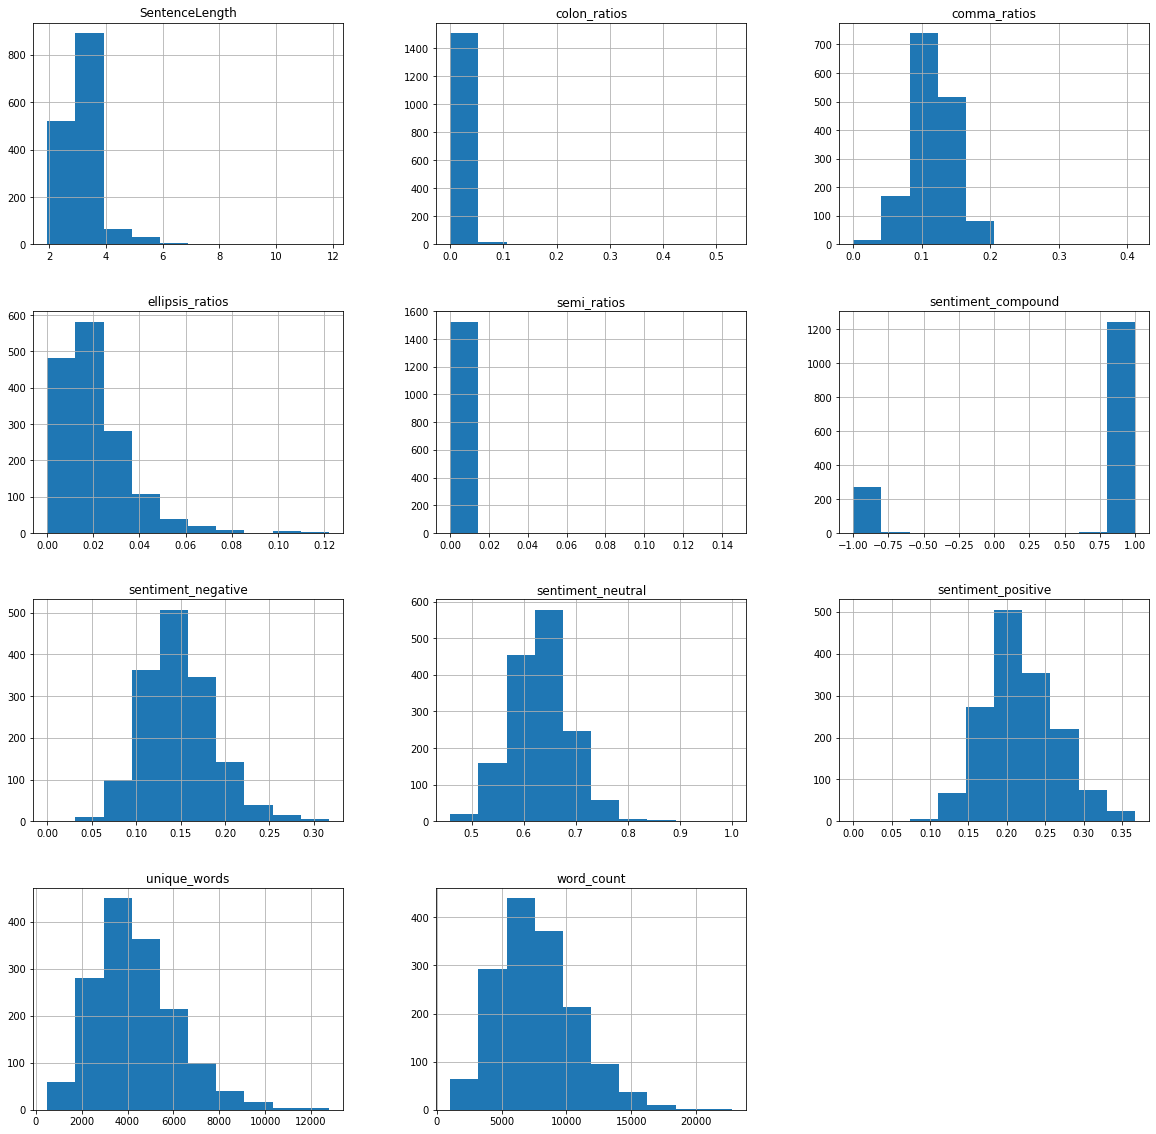

In [1473]:
temp.hist(figsize=(20,20));

In [1494]:
temp = rotten_df_cut[rotten_df_cut.columns[24:41]].copy()
temp['RottenScore'] = rotten_df_cut.RottenScores

dimensions = []

for column in temp.columns:
    dimensions.append({'label':column,'values':temp[column]})

# dimensions.append({'label':'RottenScores', 'values':rotten_df_cut.RottenScores})

In [1495]:
data = [go.Splom(
    dimensions=dimensions,
    marker={'size':2,
            'color':rotten_df_cut.RottenScores/100,
            'colorbar':{'thickness':20}
           }
)]

layout = go.Layout(height=1600,
                   width=1600)

fig = go.Figure(data, layout)
fig.show();    
# pyo.plot(fig);

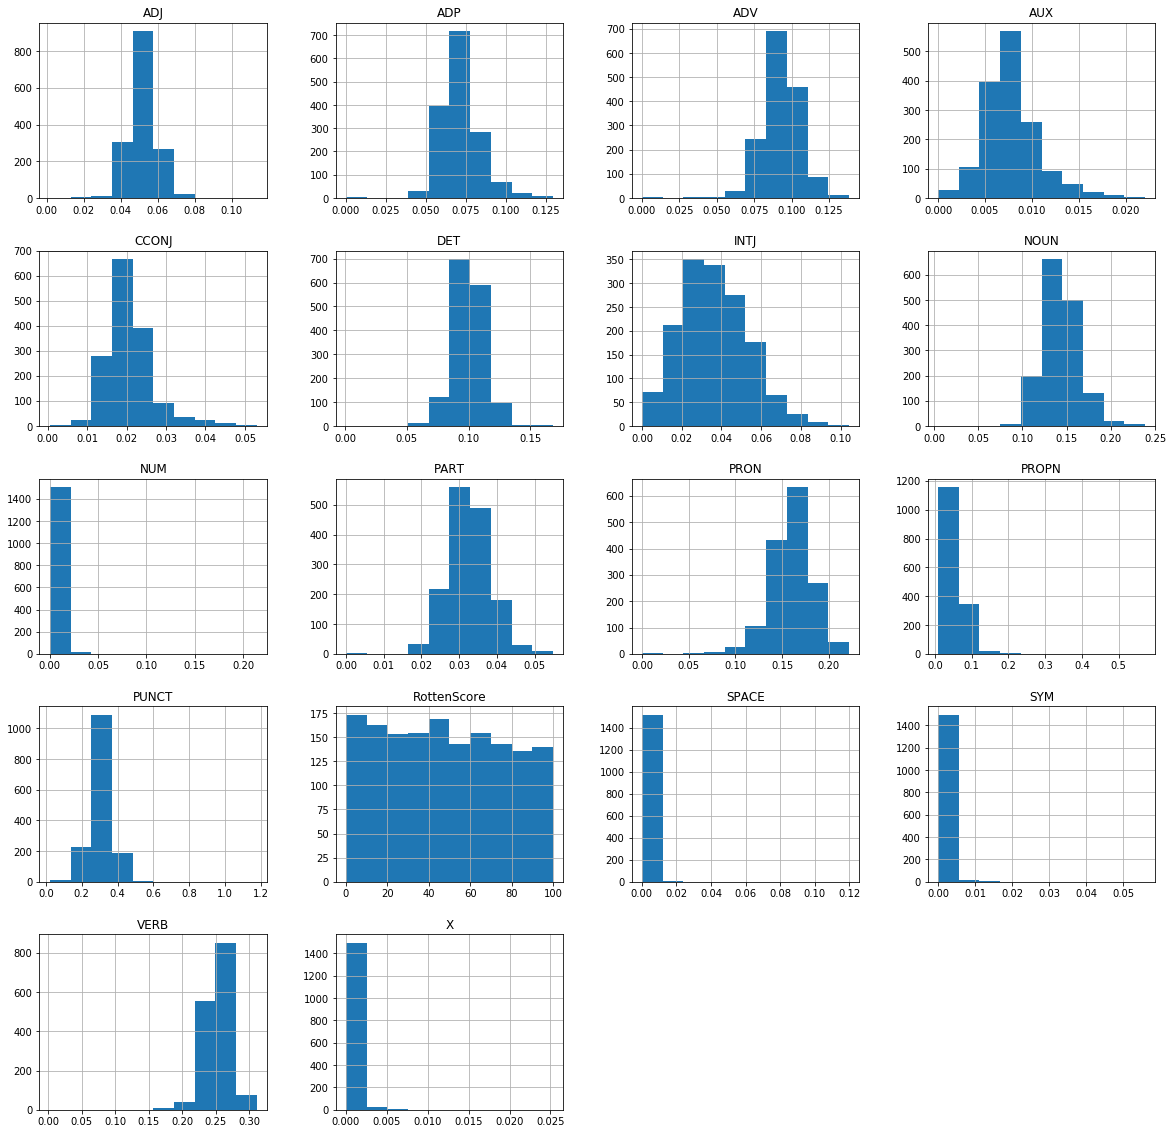

In [1496]:
temp.hist(figsize=(20,20));

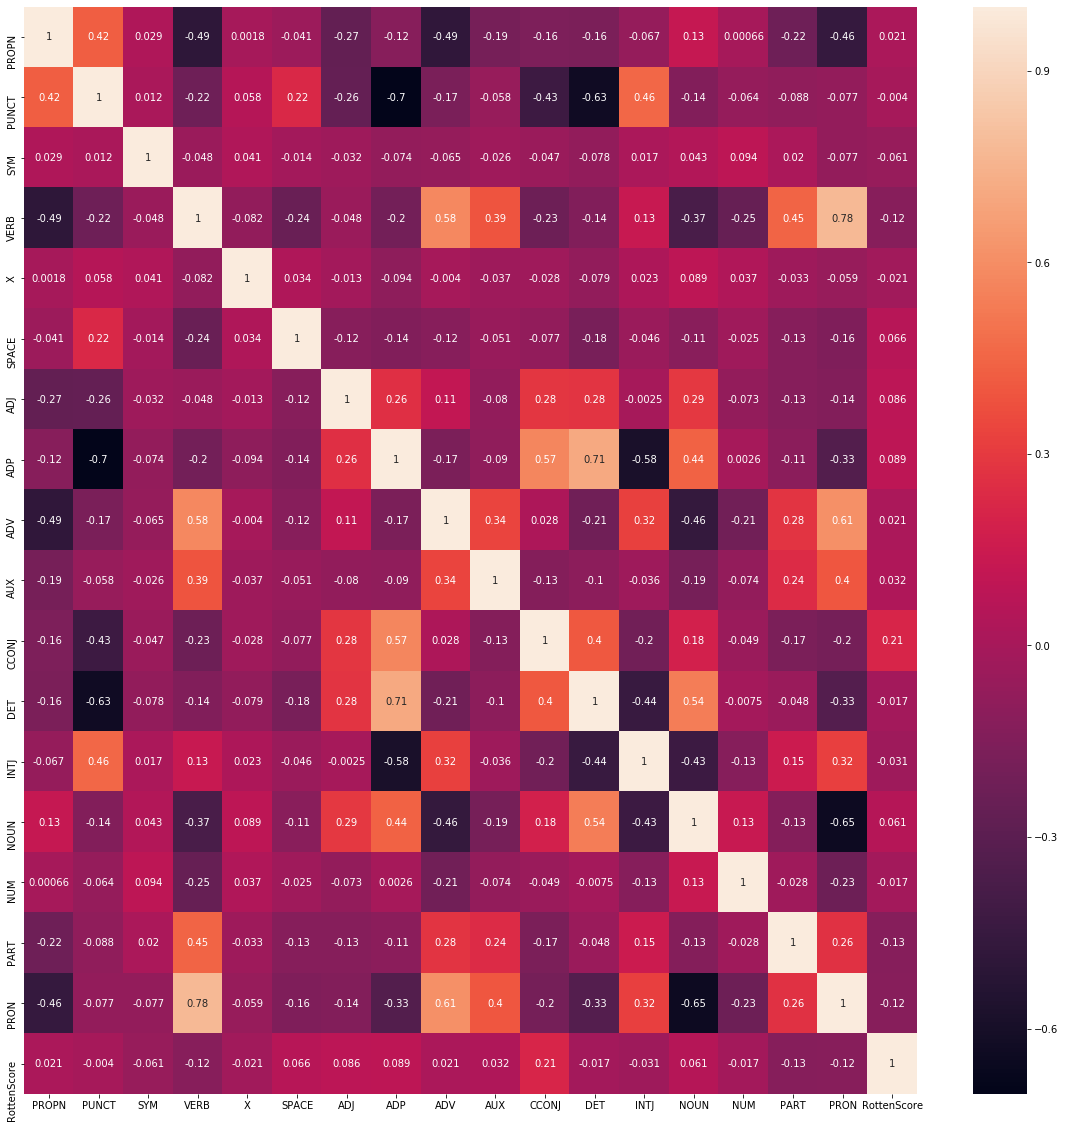

In [1497]:
plt.subplots(figsize=(20,20))
sns.heatmap(temp.corr(), annot = True)

In [1489]:
temp = rotten_df_cut[rotten_df_cut.columns[41:50]].copy()
temp['category'] = rotten_df_cut.category
temp['RottenScores'] = rotten_df_cut.RottenScores

dimensions = []

for column in temp.columns:
    dimensions.append({'label':column,'values':temp[column]})

# dimensions.append({'label':'category', 'values':rotten_df_cut.category})
# dimensions.append({'label':'RottenScores', 'values':rotten_df_cut.RottenScores})

In [1490]:
data = [go.Splom(
    dimensions=dimensions,
    marker={'size':2,
            'color':rotten_df_cut.RottenScores/100,
#             'opacity':.5,
            'colorbar':{'thickness':20},
           }
)]

layout = go.Layout(height=1600,
                   width=1600)

fig = go.Figure(data, layout)
fig.show();    
# pyo.plot(fig);

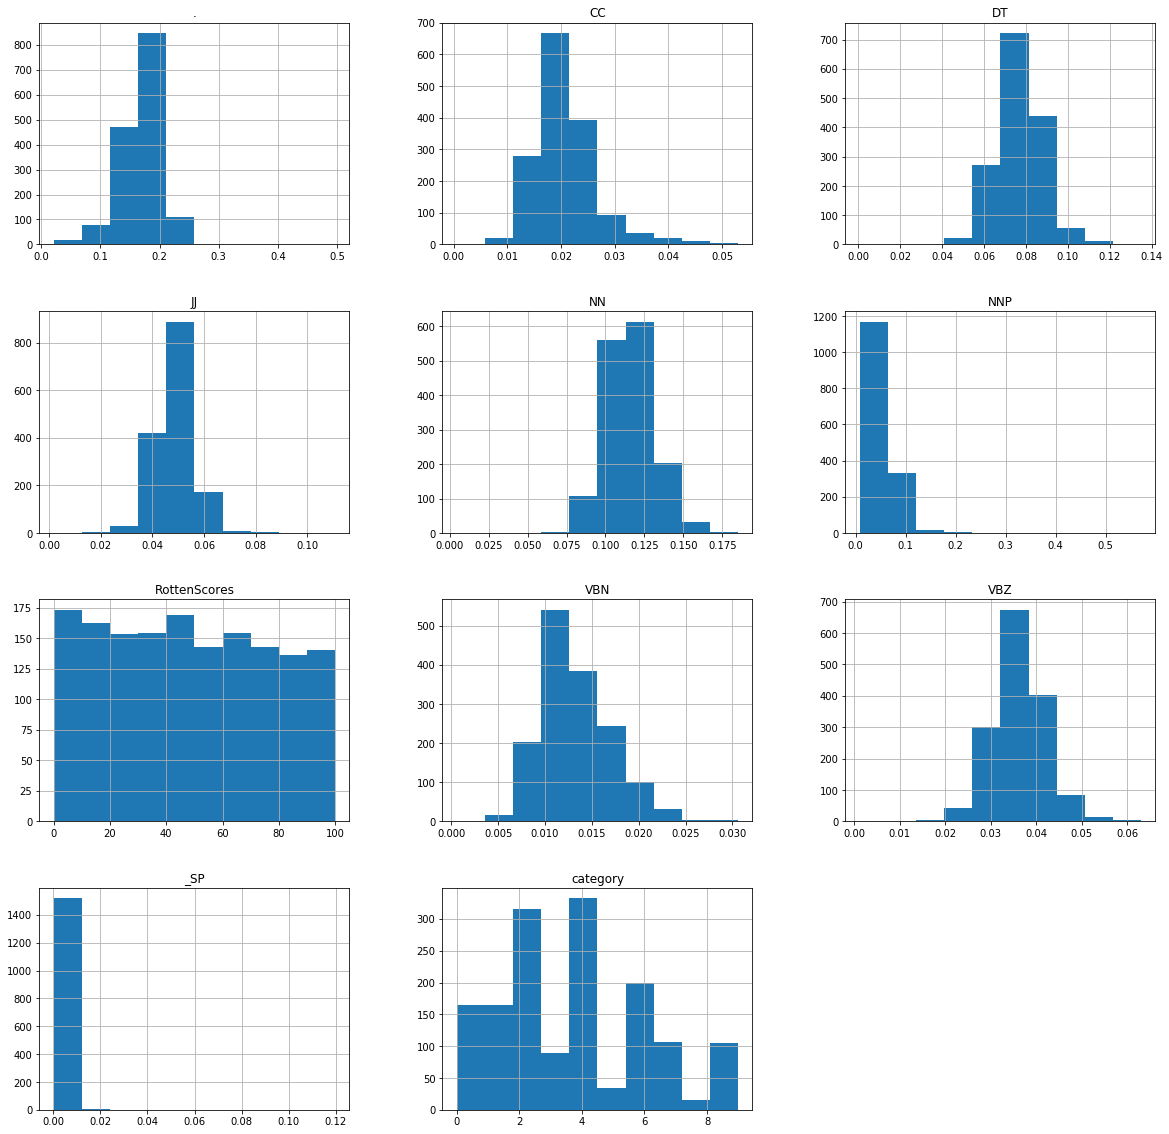

In [1491]:
temp.hist(figsize=(20,20));

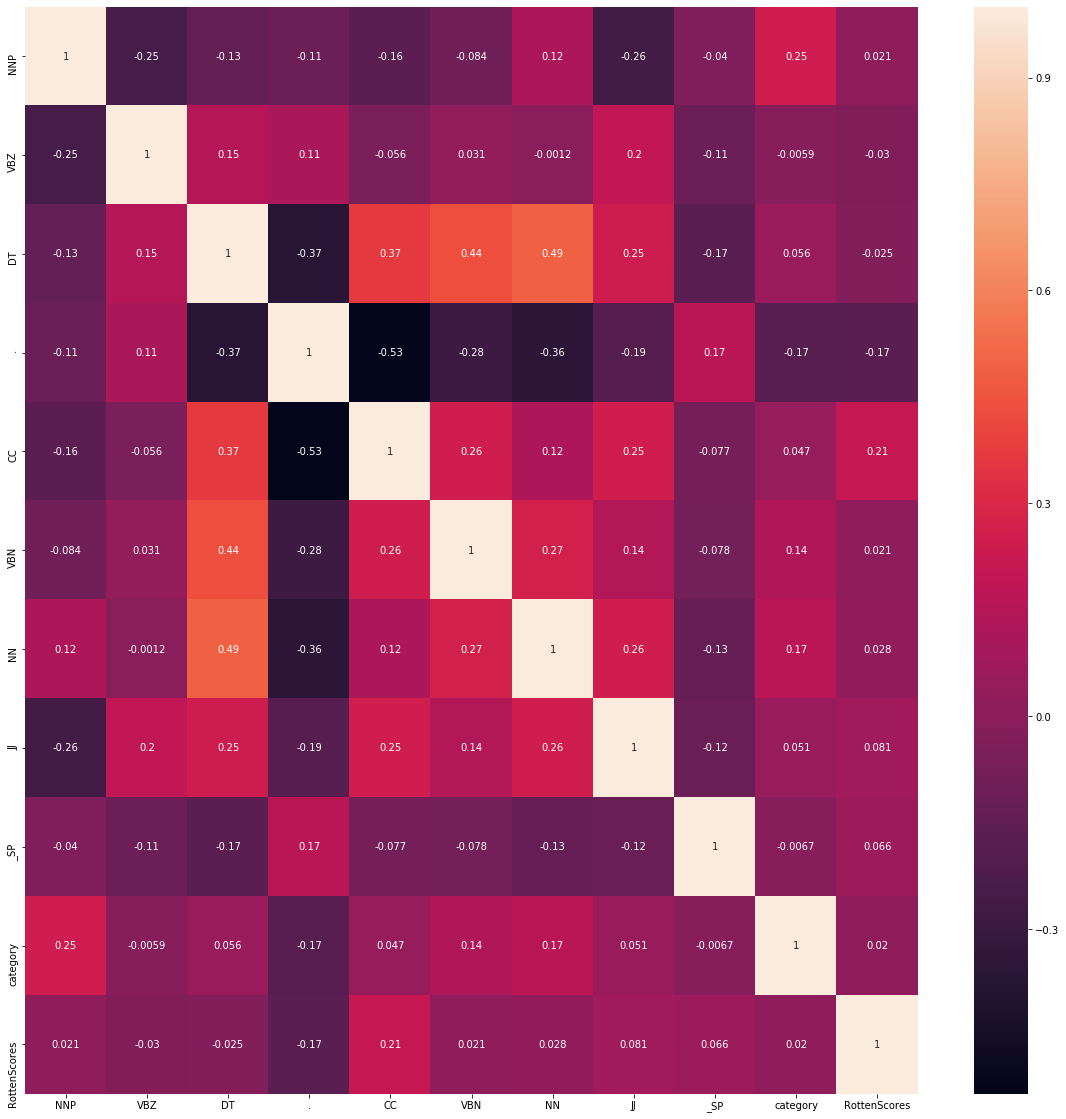

In [1492]:
plt.subplots(figsize=(20,20))
sns.heatmap(temp.corr(), annot = True)

# Modeling

## Text Embedding

### Neural Network

In [705]:
X = screenplays_cut['no_stop']
y = screenplays_cut['good_or_bad']

In [706]:
X = X.loc[~X.index.duplicated(keep='first')]
y = y.loc[~y.index.duplicated(keep='first')]

In [707]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,
                                                    random_state=42)

In [312]:
rus = RandomUnderSampler(random_state=42)
Xt_resampled, yt_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)

In [313]:
Xt_resampled = Xt_resampled['no_stop']

In [681]:
X_shuffled = shuffle(Xt_resampled, random_state=42)
y_shuffled = shuffle(yt_resampled, random_state=42)

In [717]:
tokenizer = text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_shuffled)
list_tokenized_scripts = tokenizer.texts_to_sequences(X_shuffled)
# X_t_train = list_tokenized_scripts
X_t_train = sequence.pad_sequences(list_tokenized_scripts, maxlen=5000)

In [ ]:
X_tf_train = tf.variable(X_t_train)

In [718]:
# X_t_train = np.array([np.array(item) for item in list_tokenized_scripts])

In [719]:
# y_t_train = pd.get_dummies(yt_resampled)
# X_t_train = np.array(Xt_resampled)
# y_t_train = yt_resampled
y_t_train = y_shuffled

In [738]:
model = Sequential()

embedding_size = 128
model.add(Embedding(5000, embedding_size))
model.add(LSTM(128, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [739]:
model.compile(loss='mean_squared_error',
              optimizer='adam', 
              metrics=['accuracy'])

In [740]:
# model.summary()

In [741]:
model.fit(X_t_train, y_t_train, epochs=10, batch_size=50, validation_split=0.1)

//anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1710 samples, validate on 190 samples
Epoch 1/10
1710/1710 [==============================] - 240s 140ms/step - loss: 0.2480 - accuracy: 0.5491 - val_loss: 0.2442 - val_accuracy: 0.5474
Epoch 2/10
1710/1710 [==============================] - 234s 137ms/step - loss: 0.2240 - accuracy: 0.6708 - val_loss: 0.2206 - val_accuracy: 0.6263
Epoch 3/10
1710/1710 [==============================] - 238s 139ms/step - loss: 0.1792 - accuracy: 0.7409 - val_loss: 0.2174 - val_accuracy: 0.6526
Epoch 4/10
1710/1710 [==============================] - 213s 125ms/step - loss: 0.1158 - accuracy: 0.8544 - val_loss: 0.2096 - val_accuracy: 0.6947
Epoch 5/10
1710/1710 [==============================] - 217s 127ms/step - loss: 0.0494 - accuracy: 0.9509 - val_loss: 0.2265 - val_accuracy: 0.6684
Epoch 6/10
1710/1710 [==============================] - 214s 125ms/step - loss: 0.0117 - accuracy: 0.9918 - val_loss: 0.2396 - val_accuracy: 0.6789
Epoch 7/10
1710/1710 [==============================] - 214s 125m

In [742]:
# X_t_test = X_test

In [743]:
tokenizer = text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(list(X_test))
list_tokenized_scripts = tokenizer.texts_to_sequences(X_test)
X_t_test = sequence.pad_sequences(list_tokenized_scripts, maxlen=5000)

In [744]:
# y_t_test = pd.get_dummies(y_test)
y_t_test = y_test

In [745]:
model.metrics_names

['loss', 'accuracy']

In [746]:
model.evaluate(X_t_test, y_t_test, verbose=1)

687/687 [==============================] - 15s 23ms/step


[0.34933324242783426, 0.5531295537948608]

              precision    recall  f1-score   support

           0       0.64      0.46      0.54       383
           1       0.50      0.66      0.57       304

    accuracy                           0.55       687
   macro avg       0.57      0.56      0.55       687
weighted avg       0.57      0.55      0.55       687



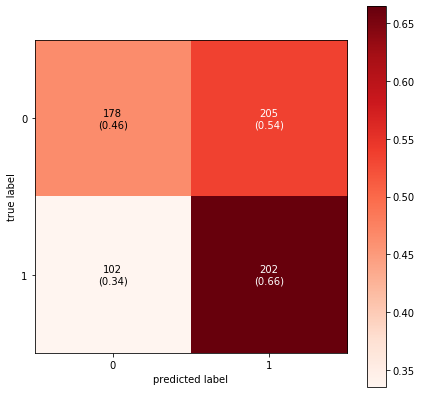

In [747]:
y_pred = model.predict_classes(X_t_test)

print(classification_report(y_t_test, y_pred))

confusion = confusion_matrix(y_t_test, y_pred)
plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                  show_normed=True, cmap=plt.cm.Reds);
plt.show();

### Script Attributes

In [180]:
X = screenplays_cut['no_stop']
y = screenplays_cut['good_or_bad']

In [181]:
dummy_cats = pd.get_dummies(screenplays_cut['category'])

In [182]:
# columns = ['colon_ratios', 'semi_ratios', 'comma_ratios', 'ellipsis_ratios']
columns = []
for column in screenplays_cut.columns[23:38]:
    columns.append(column)
    
for column in screenplays_cut.columns[39:56]:
    columns.append(column)
    
X = screenplays_cut[columns]

y = screenplays_cut.good_or_bad

In [183]:
# X = dummy_cats

In [184]:
X = X.loc[~X.index.duplicated(keep='first')]
y = y.loc[~y.index.duplicated(keep='first')]

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                    random_state=42)

In [186]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [187]:
X_train = pd.DataFrame(X_train)

0         1         2         3         4         5         6   \
0 -0.273492 -0.225662  0.765905 -0.086741 -0.094433  0.723884 -0.203092   
1 -0.270825 -0.218548 -0.753853 -0.228579 -0.053320 -0.326828  0.498075   
2 -1.331790 -0.250547  1.706758 -0.228579  0.205545 -0.441798  0.285831   
3  0.047137 -0.091172  0.068026 -0.228579 -0.054039 -0.660896  0.031759   
4 -0.574773 -0.250547 -1.013616 -0.228579  0.079074  0.704838  1.491541   

         7         8         9         10        11        12        13  \
0  0.368610  0.333668 -0.503659 -0.102054 -0.701729 -0.366487 -0.174449   
1 -0.626150 -0.368660 -0.690233  0.241976 -0.501383  0.697709  0.120760   
2  0.958720 -0.143634 -1.842435 -0.072690 -0.491831 -0.477710  0.051440   
3  0.336273  0.317285 -0.046384  0.540478  0.031162  0.254744 -0.330863   
4 -0.964807 -0.619531  1.604068  1.316164 -0.712869  1.909252  0.567409   

         14        15        16        17        18        19        20  \
0  0.250314 -0.701729 -0.824733  1.634333 -0.325992  0.215458 -0.203092   
1  1.472127 -0.501383  0.982274  0.758994 -0.831823  0.881259  0.498075   
2  0.604547 -0.491831 -0.556554 -0.002592 -1.197937 -0.262651  0.285831   
3 -0.114927  0.031162 -0.835408  0.520958  0.657295 -0.203304  0.031759   
4 -1.145897 -0.712869 -0.789665 -0.153406  0.110264  0.685845  1.491541   

         21        22        23        24        25        26        27  \
0  0.218128 -0.503659 -0.163505 -0.266968  0.616972  0.778605  0.489012   
1  0.011818 -0.690233  0.474784  0.340994 -0.502425 -1.180770 -0.831463   
2 -0.454573 -1.842435 -0.400062 -0.455872 -0.285855  0.796337  0.392820   
3 -0.015759 -0.046384 -0.810787  0.256958 -0.551147  0.240412  0.100569   
4 -0.000812  1.604068  1.182149  1.452382  0.689573 -0.561903 -1.015278   

         28        29        30        31  
0  0.362617  0.017416 -0.094433 -0.435834  
1 -0.728376  0.114732 -0.053320  1.204504  
2  1.917269 -0.186313  0.205545 -0.326362  
3  0.246350 -0.339811 -0.054039  0.142979  
4 -0.676386 -0.782117  0.079074  2.132528

In [189]:
rus = RandomUnderSampler(random_state=42)
Xt_resampled, yt_resampled = rus.fit_resample(X_train, y_train)

In [190]:
# y_t_train = pd.get_dummies(yt_resampled)
X_t_train = np.array(Xt_resampled)
y_t_train = np.array(yt_resampled)

In [192]:
model = Sequential()

# embedding_size = 128
# model.add(Embedding(20000, embedding_size))
# model.add(LSTM(128, return_sequences=True))
# model.add(GlobalMaxPool1D())
model.add(Dense(64, input_dim=32, activation='relu'))
model.add(Dense(32, input_dim=64, activation='relu'))
model.add(Dense(16, input_dim=32, activation='relu'))
# model.add(Dense(30, activation='relu'))
# model.add(Dense(30, activation='relu'))
# model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



# model.add(Dense(8, input_dim=4, activation='relu'))
# model.add(Dense(8, input_dim=4, activation='relu'))

# embedding_size = 128
# model.add(Embedding(20000, embedding_size))
# model.add(LSTM(25, return_sequences=True))
# model.add(GlobalMaxPool1D())
# model.add(Dropout(0.5))
# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

In [193]:
model.compile(loss='mean_squared_error',
              optimizer='adam', 
              metrics=['accuracy'])

In [194]:
# model.summary()

In [195]:
model.fit(X_t_train, y_t_train, epochs=8, batch_size=50, validation_split=0.1)

Train on 1593 samples, validate on 177 samples
Epoch 1/8
1593/1593 [==============================] - 0s 123us/step - loss: 0.2453 - accuracy: 0.5342 - val_loss: 0.2241 - val_accuracy: 0.5028
Epoch 2/8
1593/1593 [==============================] - 0s 27us/step - loss: 0.2201 - accuracy: 0.6667 - val_loss: 0.2405 - val_accuracy: 0.4915
Epoch 3/8
1593/1593 [==============================] - 0s 27us/step - loss: 0.2093 - accuracy: 0.6855 - val_loss: 0.2473 - val_accuracy: 0.5141
Epoch 4/8
1593/1593 [==============================] - 0s 25us/step - loss: 0.2033 - accuracy: 0.6937 - val_loss: 0.2480 - val_accuracy: 0.5254
Epoch 5/8
1593/1593 [==============================] - 0s 25us/step - loss: 0.1979 - accuracy: 0.7062 - val_loss: 0.2545 - val_accuracy: 0.5198
Epoch 6/8
1593/1593 [==============================] - 0s 28us/step - loss: 0.1932 - accuracy: 0.7194 - val_loss: 0.2590 - val_accuracy: 0.5254
Epoch 7/8
1593/1593 [==============================] - 0s 25us/step - loss: 0.1880 - acc

In [196]:
X_t_test = X_test

In [197]:
# y_t_test = pd.get_dummies(y_test)
y_t_test = y_test

In [198]:
model.metrics_names

['loss', 'accuracy']

In [199]:
model.evaluate(X_t_test, y_t_test, verbose=1)

824/824 [==============================] - 0s 16us/step


[0.20185508137767755, 0.6856796145439148]

              precision    recall  f1-score   support

           0       0.69      0.78      0.73       455
           1       0.68      0.57      0.62       369

    accuracy                           0.69       824
   macro avg       0.68      0.68      0.68       824
weighted avg       0.68      0.69      0.68       824



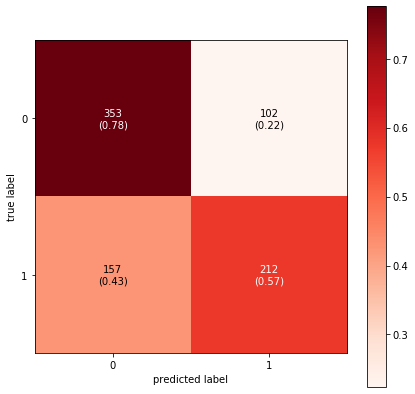

In [200]:
y_pred = model.predict_classes(X_t_test)

print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                  show_normed=True, cmap=plt.cm.Reds);
plt.show();

### TFIDF Vectorization with Script Attributes

In [ ]:
X_test = pd.DataFrame(X_test)

In [339]:
dummy_cats = pd.get_dummies(screenplays_cut['category'])

In [340]:
# columns = ['colon_ratios', 'semi_ratios', 'comma_ratios', 'ellipsis_ratios']
columns = []
for column in screenplays_cut.columns[23:38]:
    columns.append(column)
    
for column in screenplays_cut.columns[39:56]:
    columns.append(column)
    
X = screenplays_cut[columns]

X = pd.merge(screenplays_cut[columns], dummy_cats, on='titles')
y = screenplays_cut.good_or_bad

In [341]:
X2 = screenplays_cut['no_stop']
# y = screenplays_cut['good_or_bad']

In [342]:
X = X.loc[~X.index.duplicated(keep='first')]
X2 = X2.loc[~X.index.duplicated(keep='first')]
y = y.loc[~y.index.duplicated(keep='first')]

In [343]:
tfidf = TfidfVectorizer(max_features=5000, max_df=.95, min_df=.1, 
                        ngram_range=(1,2))
X2 = tfidf.fit_transform(X2)

In [344]:
X_sdf = pd.SparseDataFrame(X2, columns=tfidf.get_feature_names(),
                           default_fill_value=0)

X = X.reset_index(drop=True)

for column in X:
    X_sdf[column] = X[column]

In [345]:
X_train, X_test, y_train, y_test = train_test_split(X_sdf, y, test_size=.3,
                                                    random_state=42)

In [346]:
X_train = pd.DataFrame(X_train)

In [347]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)

In [348]:
if type(X_resampled) == pd.core.series.Series:
    X_resampled = X_resampled.iloc[:, 0]

In [349]:
# X_train = pd.SparseDataFrame(X_train, columns=tfidf.get_feature_names(),
#                            default_fill_value=0)

In [664]:
X_shuffled = shuffle(X_resampled, random_state=42)
y_shuffled = shuffle(y_resampled, random_state=42)

In [665]:
y_shuffled.head()

974    1
275    0
411    0
962    1
518    0
Name: good_or_bad, dtype: int64

In [666]:
X_shuffled.head(10)

00       000        10  10 minutes  10 years       100        11  \
974   0.000000  0.123309  0.006836    0.000000  0.000000  0.009088  0.000000   
275   0.000000  0.005177  0.000000    0.000000  0.000000  0.000000  0.000000   
411   0.000000  0.000000  0.023249    0.000000  0.000000  0.020605  0.000000   
962   0.005506  0.051829  0.022987    0.000000  0.009374  0.006112  0.000000   
518   0.007717  0.007264  0.000000    0.000000  0.000000  0.000000  0.000000   
1252  0.038458  0.152034  0.064220    0.000000  0.000000  0.059762  0.018887   
1085  0.000000  0.000000  0.000000    0.000000  0.000000  0.000000  0.000000   
344   0.000000  0.000000  0.020610    0.014068  0.014008  0.000000  0.010102   
1050  0.006754  0.006358  0.016918    0.000000  0.000000  0.014994  0.000000   
1457  0.000000  0.000000  0.000000    0.000000  0.000000  0.000000  0.000000   

            12   13        14        15  15 minutes        16        17  \
974   0.000000  0.0  0.000000  0.008153    0.013721  0.000000  0.000000   
275   0.000000  0.0  0.000000  0.000000    0.000000  0.000000  0.000000   
411   0.019107  0.0  0.026009  0.018484    0.000000  0.000000  0.000000   
962   0.000000  0.0  0.000000  0.005483    0.000000  0.007687  0.007824   
518   0.000000  0.0  0.000000  0.000000    0.000000  0.000000  0.000000   
1252  0.007917  0.0  0.000000  0.007659    0.000000  0.010737  0.010929   
1085  0.000000  0.0  0.000000  0.000000    0.000000  0.000000  0.000000   
344   0.000000  0.0  0.000000  0.000000    0.000000  0.000000  0.000000   
1050  0.006952  0.0  0.000000  0.006726    0.000000  0.000000  0.000000   
1457  0.000000  0.0  0.000000  0.000000    0.000000  0.000000  0.000000   

            18        19        20  20 minutes  20 years       200        21  \
974   0.000000  0.080287  0.077630    0.000000  0.000000  0.032967  0.000000   
275   0.000000  0.000000  0.004741    0.000000  0.008346  0.000000  0.000000   
411   0.000000  0.000000  0.016000    0.015289  0.000000  0.000000  0.000000   
962   0.014632  0.008999  0.033222    0.000000  0.016710  0.007390  0.000000   
518   0.000000  0.000000  0.000000    0.000000  0.000000  0.000000  0.000000   
1252  0.030657  0.000000  0.039777    0.000000  0.000000  0.041292  0.000000   
1085  0.000000  0.000000  0.000000    0.000000  0.000000  0.000000  0.000000   
344   0.000000  0.000000  0.000000    0.000000  0.000000  0.000000  0.026894   
1050  0.000000  0.000000  0.023287    0.000000  0.000000  0.000000  0.000000   
1457  0.000000  0.000000  0.000000    0.000000  0.000000  0.000000  0.000000   

            22       23        24  24 hours        25        30       300  \
974   0.000000  0.00000  0.000000       0.0  0.062535  0.021739  0.037116   
275   0.000000  0.00000  0.007337       0.0  0.000000  0.000000  0.000000   
411   0.000000  0.00000  0.000000       0.0  0.011815  0.000000  0.000000   
962   0.000000  0.00000  0.000000       0.0  0.007009  0.009746  0.000000   
518   0.000000  0.01321  0.000000       0.0  0.000000  0.000000  0.000000   
1252  0.012402  0.00000  0.000000       0.0  0.039164  0.006807  0.000000   
1085  0.000000  0.00000  0.000000       0.0  0.019990  0.000000  0.000000   
344   0.000000  0.00000  0.000000       0.0  0.010474  0.000000  0.000000   
1050  0.000000  0.00000  0.000000       0.0  0.000000  0.000000  0.010206   
1457  0.000000  0.00000  0.000000       0.0  0.000000  0.000000  0.000000   

            35        40       400        45        50       500        60  \
974   0.000000  0.038737  0.000000  0.000000  0.016798  0.010893  0.000000   
275   0.000000  0.000000  0.000000  0.000000  0.011283  0.000000  0.000000   
411   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
962   0.008828  0.000000  0.000000  0.008405  0.011296  0.029302  0.015589   
518   0.000000  0.000000  0.000000  0.011780  0.007916  0.000000  0.000000   
1252  0.000000  0.018195  0.013067  0.000000  0.015780  0.040931  0.010888   
1085  0.000000  0.000000  0.00

In [352]:
# X_t_Num = np.array(X_t_train)
# y_t_Num = np.array(y_resampled)

In [673]:
model = Sequential()

model.add(Dense(4441, input_dim=4441, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
# model.add(Dense(50, activation='relu'))
# model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [674]:
model.compile(loss='mean_squared_error',
              optimizer='adam', 
              metrics=['accuracy'])

In [675]:
model.fit(X_train, y_train, epochs=15, batch_size=15, 
          validation_split=0.2)

Train on 1536 samples, validate on 385 samples
Epoch 1/15
1536/1536 [==============================] - 19s 13ms/step - loss: 0.1919 - accuracy: 0.7109 - val_loss: 0.1610 - val_accuracy: 0.7636
Epoch 2/15
1536/1536 [==============================] - 20s 13ms/step - loss: 0.1095 - accuracy: 0.8464 - val_loss: 0.1626 - val_accuracy: 0.7766
Epoch 3/15
1536/1536 [==============================] - 19s 13ms/step - loss: 0.0474 - accuracy: 0.9375 - val_loss: 0.2036 - val_accuracy: 0.7532
Epoch 4/15
1536/1536 [==============================] - 20s 13ms/step - loss: 0.0229 - accuracy: 0.9707 - val_loss: 0.1368 - val_accuracy: 0.8182
Epoch 5/15
1536/1536 [==============================] - 20s 13ms/step - loss: 0.0126 - accuracy: 0.9863 - val_loss: 0.1906 - val_accuracy: 0.7766
Epoch 6/15
1536/1536 [==============================] - 20s 13ms/step - loss: 0.0073 - accuracy: 0.9909 - val_loss: 0.1705 - val_accuracy: 0.7896
Epoch 7/15
1536/1536 [==============================] - 20s 13ms/step - loss:

In [676]:
X_test = pd.DataFrame(X_test)

In [677]:
model.evaluate(X_test, y_test, verbose=1)

824/824 [==============================] - 1s 740us/step


[0.2166900574726966, 0.7536407709121704]

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       455
           1       0.69      0.81      0.75       369

    accuracy                           0.75       824
   macro avg       0.76      0.76      0.75       824
weighted avg       0.76      0.75      0.75       824



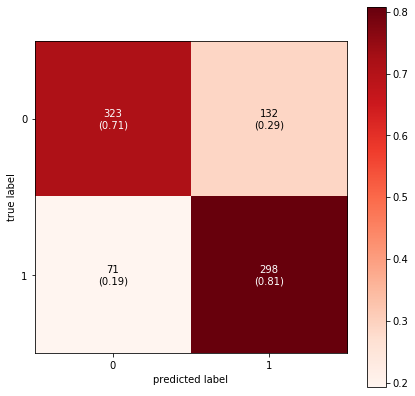

In [678]:
y_pred = model.predict_classes(X_test)

print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                  show_normed=True, cmap=plt.cm.Reds);
plt.show();

## TFID Vectorization

Screenplays DataFrame description.

    'scripts': Initial list broken out by line.
    'all_together_now': Each script made into a single string.
    'no_stop': Same as all_together_now but stop words removed.

In [241]:
screenplays.head()

scripts  \
titles                                                                
101-dalmatians    [\n\n                        [ Clock Chiming ]...   
12-angry-men      [\n\n                        You did a wonderf...   
12-years-a-slave  [\n\n                        All right now.,  ...   
127-hours         [\n\n                        Hey. Aron here, l...   
13th              [\n\n                        So let's look at ...   

                  good_or_bad  \
titles                          
101-dalmatians              1   
12-angry-men                1   
12-years-a-slave            1   
127-hours                   1   
13th                        1   

                                                   all_together_now  \
titles                                                                
101-dalmatians    \n\n                        [ Clock Chiming ] ...   
12-angry-men      \n\n                        You did a wonderfu...   
12-years-a-slave  \n\n                        All right now. Y'a...   
127-hours         \n\n                        Hey. Aron here, le...   
13th              \n\n                        So let's look at t...   

                                                            no_stop  \
titles                                                                
101-dalmatians     [ clock chiming ] [ alarm ] [ groaning ] [ wh...   
12-angry-men       wonderful job. wonderful. it. it! continue, y...   
12-years-a-slave   right now. y'all fresh niggers. y'all gonna c...   
127-hours          hey. aron here, leave message. hi aron, sonja...   
13th               let's look statistics. united states home 5% ...   

                                                         just_words  \
titles                                                                
101-dalmatians     clock chiming alarm groaning whimpering barki...   
12-angry-men       wonderful job wonderful continue youve listen...   
12-years-a-slave   right yall fresh niggers yall gonna cutting g...   
127-hours          hey aron leave message hi aron sonja hereagai...   
13th               lets look statistics united states home 5 wor...   

                                                   sentiment_scores  \
titles                                                                
101-dalmatians    {'neg': 0.129, 'neu': 0.643, 'pos': 0.227, 'co...   
12-angry-men      {'neg': 0.168, 'neu': 0.683, 'pos': 0.149, 'co...   
12-years-a-slave  {'neg': 0.163, 'neu': 0.632, 'pos': 0.204, 'co...   
127-hours         {'neg': 0.15, 'neu': 0.586, 'pos': 0.264, 'com...   
13th              {'neg': 0.236, 'neu': 0.602, 'pos': 0.162, 'co...   

                  sentiment_negative  sentiment_neutral  sentiment_positive  \
titles                                                                        
101-dalmatians                 0.129              0.643               0.227   
12-angry-men                   0.168              0.683               0.149   
12-years-a-slave               0.163              0.632               0.204   
127-hours                      0.150              0.586               0.264   
13th                           0.236              0.602               0.162   

                  sentiment_compound  word_count  unique_words  
titles                                                          
101-dalmatians                0.9999        8401          6219  
12-angry-men                 -0.9997       13144          6953  
12-years-a-slave              0.9992        8092          4291  
127-hours                     0.9996        2191          1233  
13th                         -1.0000       14231          7138

Making sure there are no empty strings in this mess.

In [242]:
# empty = []

# for t, s, g_b, a_t_n, n_s in screenplays.itertuples():
#     if type(s) == str:
#         if s.isspace():
#             empty.append(i)
            
# print(empty)

In [243]:
X = screenplays_cut.no_stop
y = screenplays_cut.good_or_bad

### Linear Support Vector Classifier

              precision    recall  f1-score   support

           0       0.80      0.75      0.77       455
           1       0.71      0.78      0.75       374

    accuracy                           0.76       829
   macro avg       0.76      0.76      0.76       829
weighted avg       0.76      0.76      0.76       829



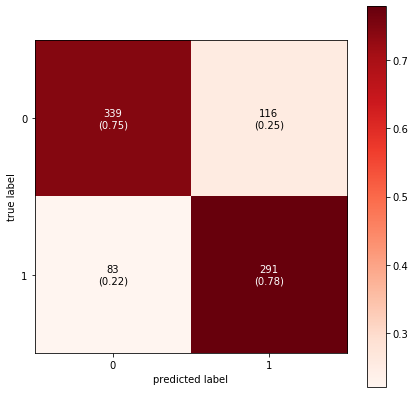

roc_auc score:  0.8358288770053477


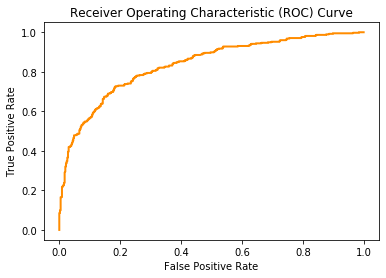

In [244]:
script_classifiers(X, y, LinearSVC(random_state=42))

### Support Vector Classifier

              precision    recall  f1-score   support

           0       0.81      0.76      0.79       455
           1       0.73      0.78      0.76       374

    accuracy                           0.77       829
   macro avg       0.77      0.77      0.77       829
weighted avg       0.77      0.77      0.77       829



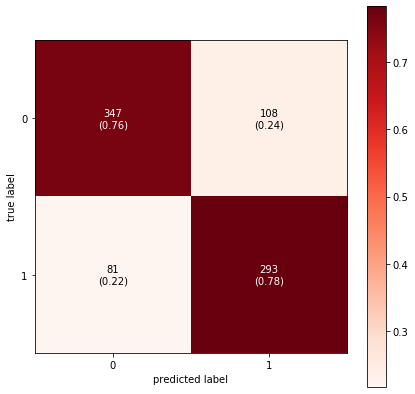

roc_auc score:  0.8386730916142681


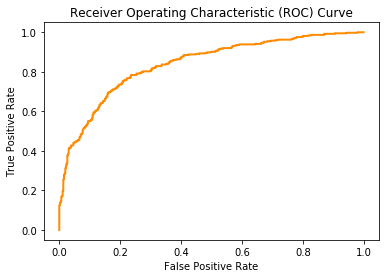

In [245]:
script_classifiers(X, y, SVC())

### Decision Tree Classifier

              precision    recall  f1-score   support

           0       0.64      0.57      0.60       455
           1       0.54      0.61      0.57       374

    accuracy                           0.59       829
   macro avg       0.59      0.59      0.59       829
weighted avg       0.59      0.59      0.59       829



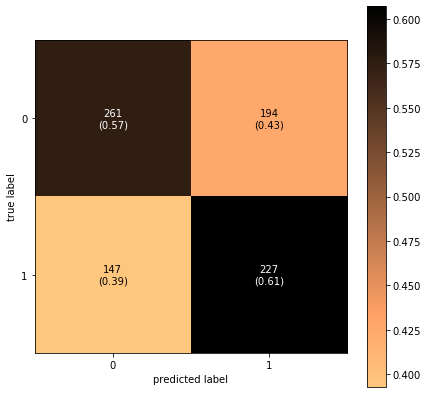

In [246]:
script_classifiers(X, y, DecisionTreeClassifier(), plt.cm.copper_r)

### Logistic Regression Classifier

              precision    recall  f1-score   support

           0       0.80      0.77      0.78       455
           1       0.73      0.76      0.74       374

    accuracy                           0.76       829
   macro avg       0.76      0.76      0.76       829
weighted avg       0.77      0.76      0.77       829



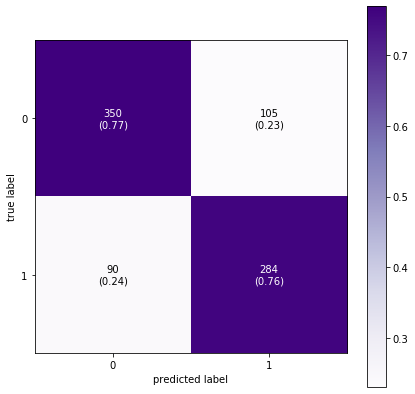

roc_auc score:  0.8328730093435975


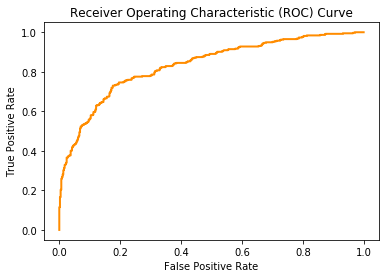

In [247]:
script_classifiers(X, y, LogisticRegression(), cmap=plt.cm.Purples)

### XG Boost Classifier

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       455
           1       0.72      0.72      0.72       374

    accuracy                           0.75       829
   macro avg       0.74      0.74      0.74       829
weighted avg       0.75      0.75      0.75       829



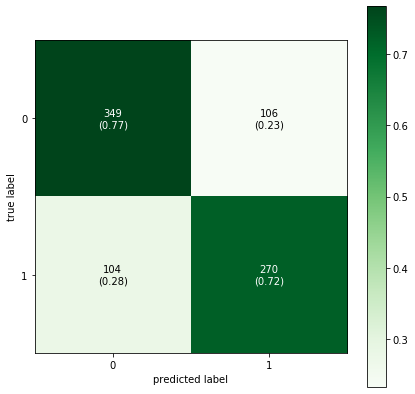

In [248]:
script_classifiers(X, y, XGBClassifier(max_depth=8,
                                        criterion='entropy',
                                        min_samples_split=14,
                                        min_samples_leaf=1,
                                        max_features=160),
                                        cmap=plt.cm.Greens)

### Random Forest Classifier

In [249]:
parameters = {
              'clf__criterion': ['entropy'],
              'clf__max_depth': [8],
              'clf__min_samples_split': [14],
              'clf__min_samples_leaf': [1],
              'clf__max_features': [160]
}
    
    
#     'criterion': ['gini', 'entropy'],
#         'max_depth': [2,3,6,7,8],
#         'min_samples_split': [2,5,10,15,20,30],
#         'min_samples_leaf': [2,5,10,15,20,30],
#         'max_features': [20,30,50,100]

In [250]:
grid_search(X, y, RandomForestClassifier(), param_grid=parameters)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   49.5s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   49.8s remaining:   33.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Mean Training Score: 97.97%
Mean Test Score: 73.46%
Best Parameter Combination Found During Grid Search:
{'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__max_features': 160, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 14}


{'clf__criterion': 'entropy',
 'clf__max_depth': 8,
 'clf__max_features': 160,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 14}

              precision    recall  f1-score   support

           0       0.74      0.78      0.76       455
           1       0.72      0.67      0.69       374

    accuracy                           0.73       829
   macro avg       0.73      0.73      0.73       829
weighted avg       0.73      0.73      0.73       829



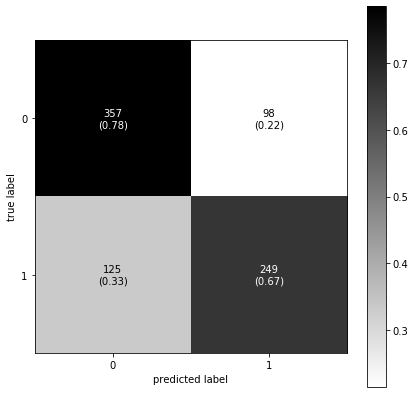

In [251]:
# parameters = {
#               'clf__criterion': ['entropy'],
#               'clf__max_depth': [8],
#               'clf__min_samples_split': [14],
#               'clf__min_samples_leaf': [1],
#               'clf__max_features': [160]

script_classifiers(X, y, RandomForestClassifier(max_depth=8,
                                                criterion='entropy',
                                                min_samples_split=14,
                                                min_samples_leaf=1,
                                                max_features=160),
                                                cmap=plt.cm.binary)

### Multinomial Bayes Classifier

              precision    recall  f1-score   support

           0       0.72      0.75      0.73       455
           1       0.67      0.64      0.66       374

    accuracy                           0.70       829
   macro avg       0.70      0.69      0.69       829
weighted avg       0.70      0.70      0.70       829



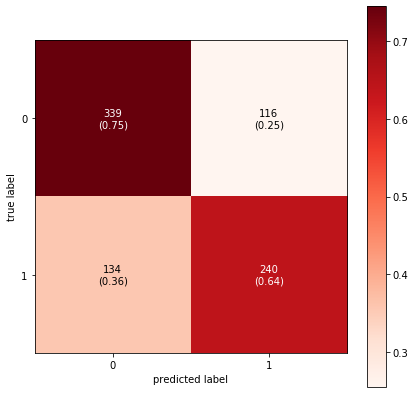

In [252]:
script_classifiers(X, y, MultinomialNB())

### Neural Network

In [201]:
X = screenplays_cut['no_stop']
y = screenplays_cut['good_or_bad']

In [202]:
X = X.loc[~X.index.duplicated(keep='first')]
y = y.loc[~y.index.duplicated(keep='first')]

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                    random_state=42)

In [204]:
X_train = pd.DataFrame(X_train)

In [205]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)

In [206]:
X_resampled = X_resampled.iloc[:, 0]

In [207]:
tfidf = TfidfVectorizer(max_features=5000, max_df=.95, min_df=.1, 
                        ngram_range=(1,2))
X_t_train = tfidf.fit_transform(X_resampled)
X_t_test = tfidf.transform(X_test)

In [208]:
X_train.shape

(1921, 1)

In [209]:
X_t_train = pd.SparseDataFrame(X_t_train, columns=tfidf.get_feature_names(),
                           default_fill_value=0)

In [210]:
X_t_train.shape

(1770, 4410)

In [211]:
X_t_Num = np.array(X_t_train)
y_t_Num = np.array(y_resampled)

In [212]:
model = Sequential()

model.add(Dense(4410, input_dim=4410, activation='relu'))
model.add(Dense(50, input_dim=4410, activation='relu'))
# model.add(Dropout(0.7))
model.add(Dense(50, input_dim=50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [213]:
model.compile(loss='mean_squared_error',
              optimizer='adam', 
              metrics=['accuracy'])

In [214]:
model.fit(X_t_Num, y_t_Num, epochs=4, batch_size=50, validation_split=0.2)

Train on 1416 samples, validate on 354 samples
Epoch 1/4
1416/1416 [==============================] - 5s 4ms/step - loss: 0.2020 - accuracy: 0.6857 - val_loss: 0.2128 - val_accuracy: 0.7119
Epoch 2/4
1416/1416 [==============================] - 5s 4ms/step - loss: 0.1182 - accuracy: 0.8475 - val_loss: 0.1799 - val_accuracy: 0.7458
Epoch 3/4
1416/1416 [==============================] - 5s 3ms/step - loss: 0.0505 - accuracy: 0.9442 - val_loss: 0.1611 - val_accuracy: 0.7740
Epoch 4/4
1416/1416 [==============================] - 5s 3ms/step - loss: 0.0206 - accuracy: 0.9809 - val_loss: 0.2956 - val_accuracy: 0.6102


In [215]:
# X_t_test = X_test

In [216]:
# tokenizer = text.Tokenizer(num_words=20000)
# tokenizer.fit_on_texts(list(X_test))
# list_tokenized_scripts = tokenizer.texts_to_sequences(X_test)
# X_t_test = sequence.pad_sequences(list_tokenized_scripts, maxlen=2000)

In [217]:
# y_t_test = pd.get_dummies(y_test)
y_t_test = y_test

In [218]:
model.metrics_names

['loss', 'accuracy']

In [219]:
model.evaluate(X_t_test, y_t_test, verbose=1)

824/824 [==============================] - 0s 300us/step


[0.17677973984803969, 0.7669903039932251]

              precision    recall  f1-score   support

           0       0.75      0.86      0.80       455
           1       0.79      0.65      0.71       369

    accuracy                           0.77       824
   macro avg       0.77      0.76      0.76       824
weighted avg       0.77      0.77      0.76       824



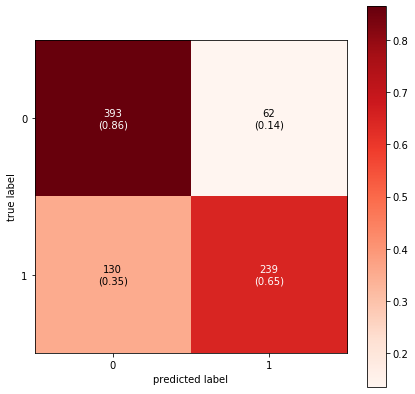

In [220]:
y_pred = model.predict_classes(X_t_test)

print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                  show_normed=True, cmap=plt.cm.Reds);
plt.show();

## Script Attributes

In [932]:
dummy_cats = pd.get_dummies(screenplays_cut['category'])

In [933]:
# columns = ['category', 'unique_words', 'word_count', 'sentence_length',
#             'sentiment_positive']
columns = ['unique_words', 'word_count', 'sentence_length', 
                    'sentiment_negative', 'sentiment_neutral', 
                    'sentiment_positive', 'sentiment_compound',
                    'ellipsis_ratios', 'semi_ratios', 'colon_ratios', 
                    'comma_ratios']
for column in screenplays_cut.columns[23:38]:
    columns.append(column)
    
# X = screenplays_cut[columns]
X = pd.merge(screenplays_cut[columns], dummy_cats, on='titles')
# X = screenplays_cut[['unique_words', 'word_count']]
y = screenplays_cut.good_or_bad

In [934]:
X = X.loc[~X.index.duplicated(keep='first')]
y = y.loc[~y.index.duplicated(keep='first')]

### Support Vector Classifier

              precision    recall  f1-score   support

           0       0.60      0.75      0.67       455
           1       0.56      0.38      0.45       369

    accuracy                           0.59       824
   macro avg       0.58      0.57      0.56       824
weighted avg       0.58      0.59      0.57       824



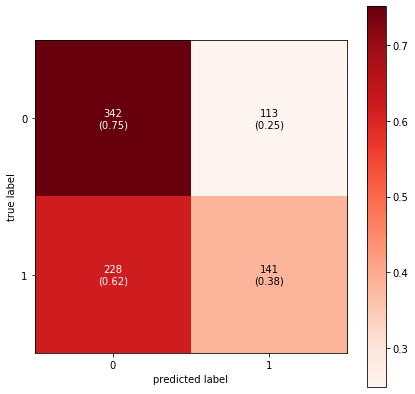

roc_auc score:  0.598117871288603


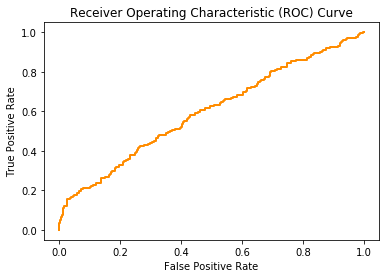

In [280]:
script_classifiers(X, y, classifier=SVC(), use_tfidf=False)

### Decision Tree Classifier

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       455
           1       0.55      0.56      0.55       369

    accuracy                           0.59       824
   macro avg       0.59      0.59      0.59       824
weighted avg       0.60      0.59      0.60       824



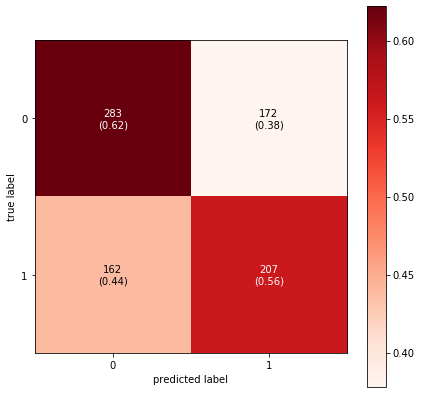

In [281]:
script_classifiers(X, y, classifier=DecisionTreeClassifier(), use_tfidf=False)

### Logistic Regression Classifier

              precision    recall  f1-score   support

           0       0.64      0.43      0.52       455
           1       0.50      0.70      0.58       369

    accuracy                           0.55       824
   macro avg       0.57      0.57      0.55       824
weighted avg       0.58      0.55      0.55       824



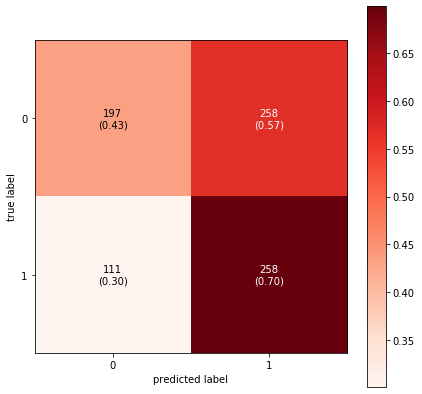

roc_auc score:  0.609708448732839


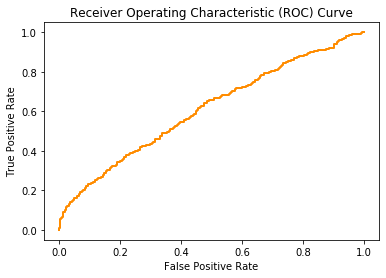

In [282]:
script_classifiers(X, y, classifier=LogisticRegression(), use_tfidf=False)

### XG Boost Classifier

              precision    recall  f1-score   support

           0       0.72      0.77      0.75       455
           1       0.69      0.63      0.66       369

    accuracy                           0.71       824
   macro avg       0.71      0.70      0.70       824
weighted avg       0.71      0.71      0.71       824



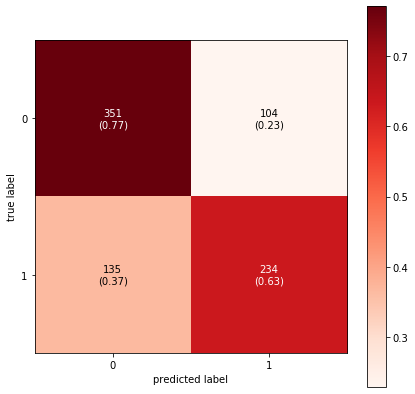

In [283]:
script_classifiers(X, y, classifier=XGBClassifier(),use_tfidf=False)

### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.72      0.78      0.75       455
           1       0.70      0.62      0.65       369

    accuracy                           0.71       824
   macro avg       0.71      0.70      0.70       824
weighted avg       0.71      0.71      0.71       824

Accuracy:  0.7087378640776699


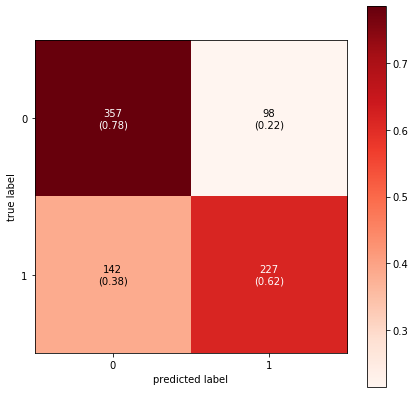

AUX                   0.098416
CCONJ                 0.089030
ADP                   0.054976
INTJ                  0.051343
word_count            0.049904
ADV                   0.045095
sentence_length       0.042269
PUNCT                 0.041800
SPACE                 0.039245
unique_words          0.036850
NUM                   0.035563
PART                  0.034585
DET                   0.034259
ADJ                   0.033593
sentiment_neutral     0.030005
sentiment_negative    0.028837
VERB                  0.027078
9                     0.026868
comma_ratios          0.025638
sentiment_positive    0.024849
ellipsis_ratios       0.022036
NOUN                  0.021342
colon_ratios          0.020582
3                     0.018635
SYM                   0.018049
X                     0.014644
sentiment_compound    0.012786
0                     0.005791
semi_ratios           0.005019
6                     0.002174
1                     0.002022
4                     0.001882
8       

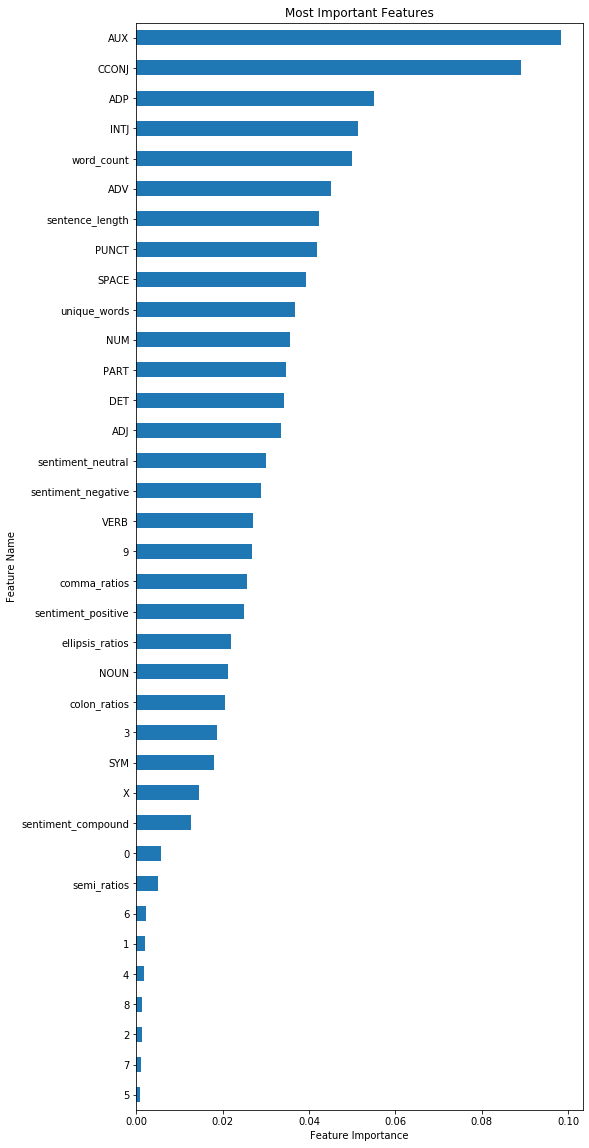

In [935]:
ceci_nest_pas_une_pipe(X, y,
                   classifier=RandomForestClassifier(random_state=42,
                                                    max_depth=8,
                                                    criterion='entropy',
                                                    min_samples_split=14,
                                                    min_samples_leaf=1,
                                                    max_features=10))

### Neural Network

In [180]:
X = screenplays_cut['no_stop']
y = screenplays_cut['good_or_bad']

In [181]:
dummy_cats = pd.get_dummies(screenplays_cut['category'])

In [182]:
# columns = ['colon_ratios', 'semi_ratios', 'comma_ratios', 'ellipsis_ratios']
columns = []
for column in screenplays_cut.columns[23:38]:
    columns.append(column)
    
for column in screenplays_cut.columns[39:56]:
    columns.append(column)
    
X = screenplays_cut[columns]

# X = pd.merge(screenplays_cut[columns], dummy_cats, on='titles')
# X = screenplays_cut[['unique_words', 'word_count']]
y = screenplays_cut.good_or_bad

In [183]:
# X = dummy_cats

In [184]:
X = X.loc[~X.index.duplicated(keep='first')]
y = y.loc[~y.index.duplicated(keep='first')]

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                    random_state=42)

In [186]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [187]:
X_train = pd.DataFrame(X_train)
X_train.head()

0         1         2         3         4         5         6   \
0 -0.273492 -0.225662  0.765905 -0.086741 -0.094433  0.723884 -0.203092   
1 -0.270825 -0.218548 -0.753853 -0.228579 -0.053320 -0.326828  0.498075   
2 -1.331790 -0.250547  1.706758 -0.228579  0.205545 -0.441798  0.285831   
3  0.047137 -0.091172  0.068026 -0.228579 -0.054039 -0.660896  0.031759   
4 -0.574773 -0.250547 -1.013616 -0.228579  0.079074  0.704838  1.491541   

         7         8         9         10        11        12        13  \
0  0.368610  0.333668 -0.503659 -0.102054 -0.701729 -0.366487 -0.174449   
1 -0.626150 -0.368660 -0.690233  0.241976 -0.501383  0.697709  0.120760   
2  0.958720 -0.143634 -1.842435 -0.072690 -0.491831 -0.477710  0.051440   
3  0.336273  0.317285 -0.046384  0.540478  0.031162  0.254744 -0.330863   
4 -0.964807 -0.619531  1.604068  1.316164 -0.712869  1.909252  0.567409   

         14        15        16        17        18        19        20  \
0  0.250314 -0.701729 -0.824733  1.634333 -0.325992  0.215458 -0.203092   
1  1.472127 -0.501383  0.982274  0.758994 -0.831823  0.881259  0.498075   
2  0.604547 -0.491831 -0.556554 -0.002592 -1.197937 -0.262651  0.285831   
3 -0.114927  0.031162 -0.835408  0.520958  0.657295 -0.203304  0.031759   
4 -1.145897 -0.712869 -0.789665 -0.153406  0.110264  0.685845  1.491541   

         21        22        23        24        25        26        27  \
0  0.218128 -0.503659 -0.163505 -0.266968  0.616972  0.778605  0.489012   
1  0.011818 -0.690233  0.474784  0.340994 -0.502425 -1.180770 -0.831463   
2 -0.454573 -1.842435 -0.400062 -0.455872 -0.285855  0.796337  0.392820   
3 -0.015759 -0.046384 -0.810787  0.256958 -0.551147  0.240412  0.100569   
4 -0.000812  1.604068  1.182149  1.452382  0.689573 -0.561903 -1.015278   

         28        29        30        31  
0  0.362617  0.017416 -0.094433 -0.435834  
1 -0.728376  0.114732 -0.053320  1.204504  
2  1.917269 -0.186313  0.205545 -0.326362  
3  0.246350 -0.339811 -0.054039  0.142979  
4 -0.676386 -0.782117  0.079074  2.132528

In [188]:
print(len(y_train[y_train == 0]))
print(len(y_train[y_train == 1]))

1036
885


In [189]:
rus = RandomUnderSampler(random_state=42)
Xt_resampled, yt_resampled = rus.fit_resample(X_train, y_train)

In [190]:
# y_t_train = pd.get_dummies(yt_resampled)
X_t_train = np.array(Xt_resampled)
y_t_train = np.array(yt_resampled)

In [191]:
X_t_train.shape

(1770, 32)

In [192]:
model = Sequential()

# embedding_size = 128
# model.add(Embedding(20000, embedding_size))
# model.add(LSTM(128, return_sequences=True))
# model.add(GlobalMaxPool1D())
model.add(Dense(64, input_dim=32, activation='relu'))
model.add(Dense(32, input_dim=64, activation='relu'))
model.add(Dense(16, input_dim=32, activation='relu'))
# model.add(Dense(30, activation='relu'))
# model.add(Dense(30, activation='relu'))
# model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



# model.add(Dense(8, input_dim=4, activation='relu'))
# model.add(Dense(8, input_dim=4, activation='relu'))

# embedding_size = 128
# model.add(Embedding(20000, embedding_size))
# model.add(LSTM(25, return_sequences=True))
# model.add(GlobalMaxPool1D())
# model.add(Dropout(0.5))
# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

In [193]:
model.compile(loss='mean_squared_error',
              optimizer='adam', 
              metrics=['accuracy'])

In [194]:
# model.summary()

In [195]:
model.fit(X_t_train, y_t_train, epochs=8, batch_size=50, validation_split=0.1)

Train on 1593 samples, validate on 177 samples
Epoch 1/8
1593/1593 [==============================] - 0s 123us/step - loss: 0.2453 - accuracy: 0.5342 - val_loss: 0.2241 - val_accuracy: 0.5028
Epoch 2/8
1593/1593 [==============================] - 0s 27us/step - loss: 0.2201 - accuracy: 0.6667 - val_loss: 0.2405 - val_accuracy: 0.4915
Epoch 3/8
1593/1593 [==============================] - 0s 27us/step - loss: 0.2093 - accuracy: 0.6855 - val_loss: 0.2473 - val_accuracy: 0.5141
Epoch 4/8
1593/1593 [==============================] - 0s 25us/step - loss: 0.2033 - accuracy: 0.6937 - val_loss: 0.2480 - val_accuracy: 0.5254
Epoch 5/8
1593/1593 [==============================] - 0s 25us/step - loss: 0.1979 - accuracy: 0.7062 - val_loss: 0.2545 - val_accuracy: 0.5198
Epoch 6/8
1593/1593 [==============================] - 0s 28us/step - loss: 0.1932 - accuracy: 0.7194 - val_loss: 0.2590 - val_accuracy: 0.5254
Epoch 7/8
1593/1593 [==============================] - 0s 25us/step - loss: 0.1880 - acc

In [196]:
X_t_test = X_test

In [197]:
# y_t_test = pd.get_dummies(y_test)
y_t_test = y_test

In [198]:
model.metrics_names

['loss', 'accuracy']

In [199]:
model.evaluate(X_t_test, y_t_test, verbose=1)

824/824 [==============================] - 0s 16us/step


[0.20185508137767755, 0.6856796145439148]

              precision    recall  f1-score   support

           0       0.69      0.78      0.73       455
           1       0.68      0.57      0.62       369

    accuracy                           0.69       824
   macro avg       0.68      0.68      0.68       824
weighted avg       0.68      0.69      0.68       824



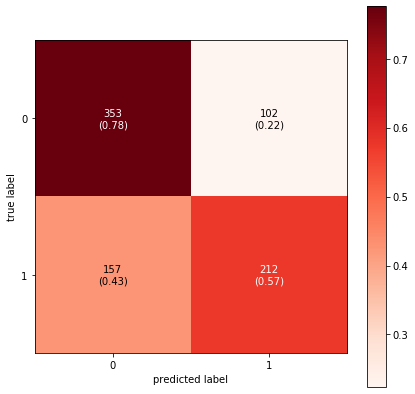

In [200]:
y_pred = model.predict_classes(X_t_test)

print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                  show_normed=True, cmap=plt.cm.Reds);
plt.show();

## TFIDF with Script Atteributes

### Setup

In [945]:
dummy_cats = pd.get_dummies(screenplays_cut['category'])

In [946]:
# POS_only = []
# for column in screenplays_cut.columns[21:38]:
#     POS_only.append(column)

# X = screenplays_cut['word_cout']
# X2 = screenplays_cut.no_stop
# y = screenplays_cut.good_or_bad

In [947]:
X = dummy_cats
X2 = screenplays_cut.no_stop
y = screenplays_cut.good_or_bad

In [948]:
X = X.loc[~X.index.duplicated(keep='first')]
y = y.loc[~y.index.duplicated(keep='first')]
X2 = X2.iloc[~X2.index.duplicated(keep='first')]

### Linear Support Vector Classifier

**This is my top model of all.**

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1036
           1       0.92      0.94      0.93       885

    accuracy                           0.94      1921
   macro avg       0.94      0.94      0.94      1921
weighted avg       0.94      0.94      0.94      1921

Accuracy:  0.937532535137949


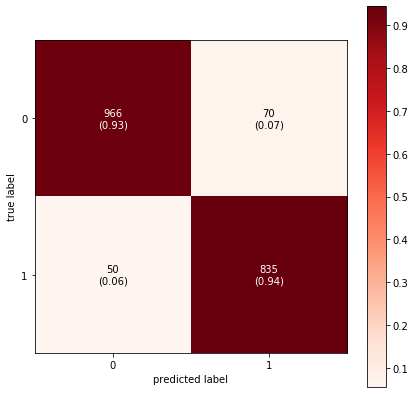

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       455
           1       0.78      0.78      0.78       369

    accuracy                           0.80       824
   macro avg       0.80      0.80      0.80       824
weighted avg       0.80      0.80      0.80       824

Accuracy:  0.8009708737864077


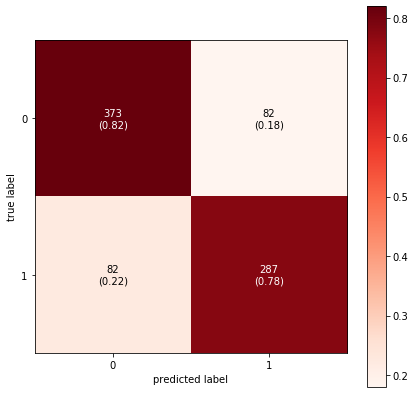

roc_auc score:  0.8496739033324399


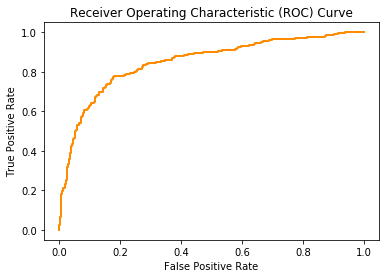

In [904]:
ceci_nest_pas_une_pipe(X, y, X2, LinearSVC(C=.6))

### Support Vector Classifier

X2 shape:  (2745, 4408)
X_sdf shape:  (2745, 4408)
              precision    recall  f1-score   support

           0       0.65      0.75      0.70      1036
           1       0.64      0.52      0.58       885

    accuracy                           0.65      1921
   macro avg       0.65      0.64      0.64      1921
weighted avg       0.65      0.65      0.64      1921

Accuracy:  0.6475793857365956


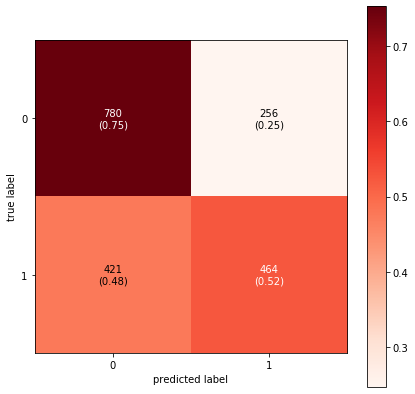

              precision    recall  f1-score   support

           0       0.65      0.79      0.72       455
           1       0.65      0.48      0.55       369

    accuracy                           0.65       824
   macro avg       0.65      0.64      0.63       824
weighted avg       0.65      0.65      0.64       824

Accuracy:  0.6516990291262136


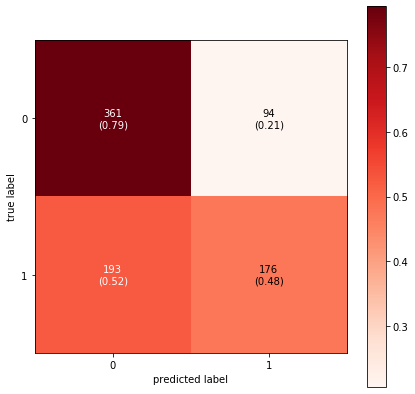

roc_auc score:  0.7436671729354656


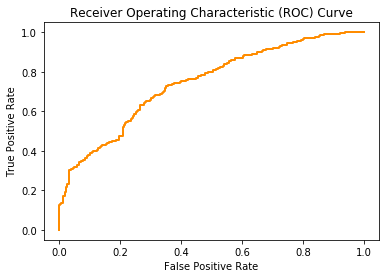

In [589]:
ceci_nest_pas_une_pipe(X, y, X2, SVC(C=.1))

### Decision Tree Classifier

X2 shape:  (2745, 4408)
X_sdf shape:  (2745, 4408)
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1036
           1       0.94      1.00      0.97       885

    accuracy                           0.97      1921
   macro avg       0.97      0.97      0.97      1921
weighted avg       0.97      0.97      0.97      1921

Accuracy:  0.9729307652264445


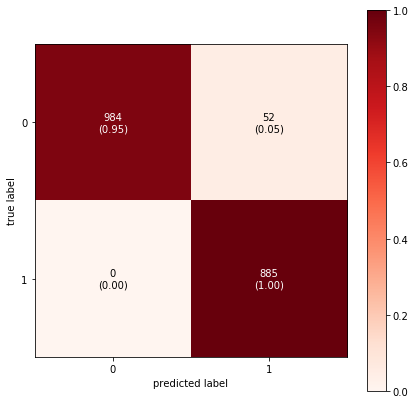

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       455
           1       0.55      0.57      0.56       369

    accuracy                           0.60       824
   macro avg       0.60      0.60      0.60       824
weighted avg       0.60      0.60      0.60       824

Accuracy:  0.5983009708737864


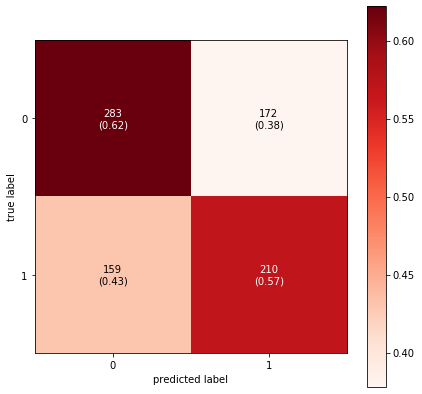

In [585]:
ceci_nest_pas_une_pipe(X, y, X2, DecisionTreeClassifier())

### Logistic Regression Classifier

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1036
           1       0.94      0.97      0.95       885

    accuracy                           0.96      1921
   macro avg       0.96      0.96      0.96      1921
weighted avg       0.96      0.96      0.96      1921

Accuracy:  0.9578344612181156


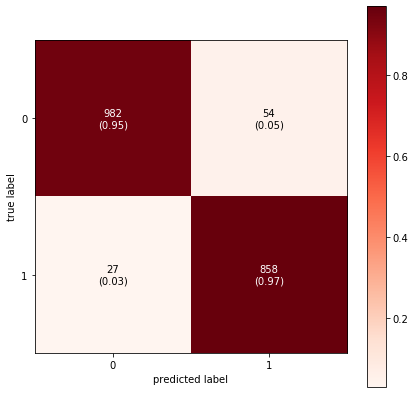

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       455
           1       0.76      0.77      0.77       369

    accuracy                           0.79       824
   macro avg       0.79      0.79      0.79       824
weighted avg       0.79      0.79      0.79       824

Accuracy:  0.7900485436893204


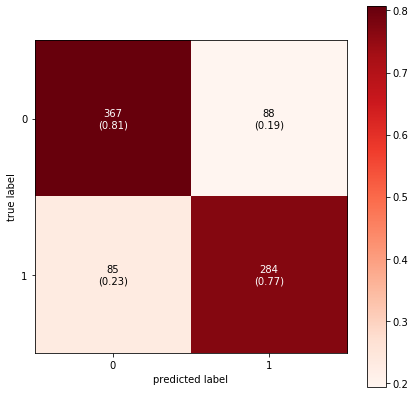

roc_auc score:  0.8501027427856697


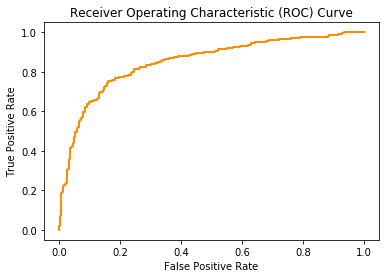

In [908]:
ceci_nest_pas_une_pipe(X, y, X2, LogisticRegression(C=10))

### XG Boost Classifier

In [587]:
# ceci_nest_pas_une_pipe(X, y, X2, XGBClassifier())
# XG Boost did not like the sparse dataframe for some reason. Skipping.

### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.73      0.80      0.76       455
           1       0.72      0.64      0.67       369

    accuracy                           0.72       824
   macro avg       0.72      0.72      0.72       824
weighted avg       0.72      0.72      0.72       824

Accuracy:  0.7245145631067961


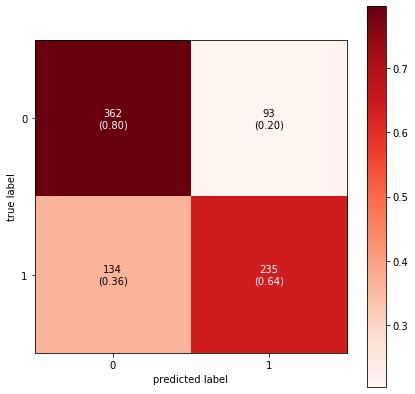

come on          0.006630
oh god           0.005395
guys             0.004284
wait             0.004009
hey              0.003717
god              0.003707
no no            0.003437
whoa             0.003358
hey hey          0.003347
bit              0.003114
okay             0.002996
ass              0.002879
guy              0.002779
huh              0.002619
please           0.002594
won              0.002575
know what        0.002522
wouldn           0.002430
freak            0.002391
go go            0.002309
let go           0.002298
hi               0.002270
hell             0.002249
kidding          0.002220
sorry            0.002175
suppose          0.002171
yeah             0.002073
re gonna         0.002019
dude             0.001956
damn             0.001928
plan             0.001885
on come          0.001850
kidding me       0.001827
hey guys         0.001818
love you         0.001774
check            0.001764
thanks           0.001718
help me          0.001681
9           

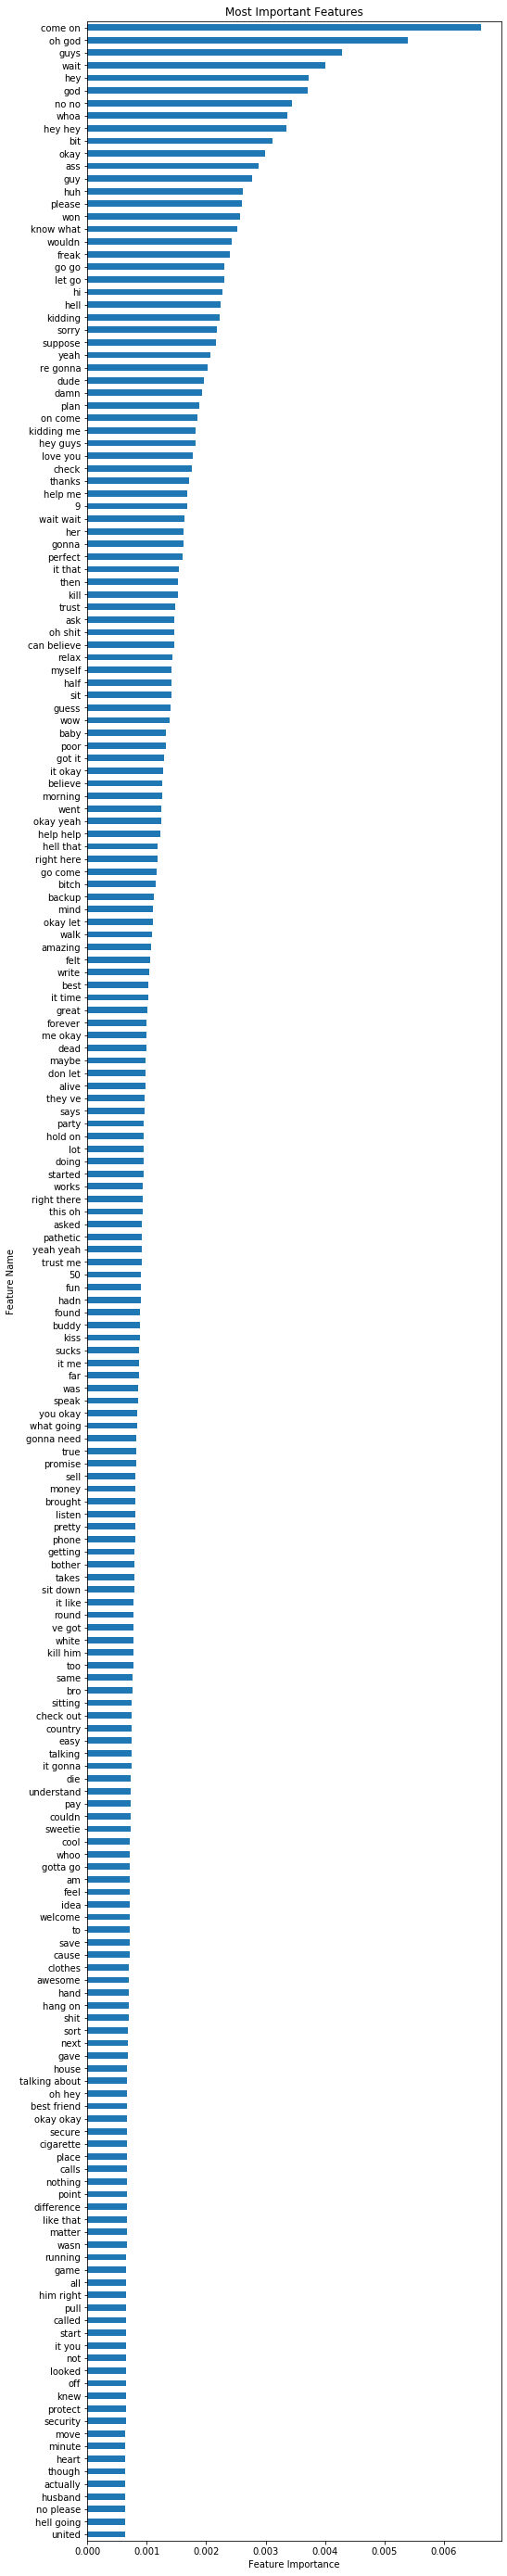

In [956]:
ceci_nest_pas_une_pipe(X, y, X2, RandomForestClassifier(random_state=42, 
                                                       n_jobs=-1))

### Neural Network

In [878]:
X = screenplays_cut['no_stop']
y = screenplays_cut['good_or_bad']

In [879]:
dummy_cats = pd.get_dummies(screenplays_cut['category'])

In [880]:
# columns = ['colon_ratios', 'semi_ratios', 'comma_ratios', 'ellipsis_ratios']
columns = []
for column in screenplays_cut.columns[23:38]:
    columns.append(column)
    
for column in screenplays_cut.columns[39:56]:
    columns.append(column)
    
X = screenplays_cut[columns]

X = pd.merge(screenplays_cut[columns], dummy_cats, on='titles')
y = screenplays_cut.good_or_bad

In [881]:
X2 = screenplays_cut['no_stop']
# y = screenplays_cut['good_or_bad']

In [882]:
X = X.loc[~X.index.duplicated(keep='first')]
X2 = X2.loc[~X.index.duplicated(keep='first')]
y = y.loc[~y.index.duplicated(keep='first')]

In [883]:
tfidf = TfidfVectorizer(max_features=5000, max_df=.95, min_df=.1, 
                        ngram_range=(1,2))
X2 = tfidf.fit_transform(X2)

In [884]:
X_sdf = pd.SparseDataFrame(X2, columns=tfidf.get_feature_names(),
                           default_fill_value=0)

X = X.reset_index(drop=True)

for column in X:
    X_sdf[column] = X[column]

In [885]:
X_train, X_test, y_train, y_test = train_test_split(X_sdf, y, test_size=.3,
                                                    random_state=42)

In [886]:
X_train = pd.DataFrame(X_train)

In [887]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)

In [888]:
if type(X_resampled) == pd.core.series.Series:
    X_resampled = X_resampled.iloc[:, 0]

In [889]:
# X_train = pd.SparseDataFrame(X_train, columns=tfidf.get_feature_names(),
#                            default_fill_value=0)

In [890]:
X_shuffled = shuffle(X_resampled, random_state=42)
y_shuffled = shuffle(y_resampled, random_state=42)

In [891]:
# X_t_Num = np.array(X_t_train)
# y_t_Num = np.array(y_resampled)

In [892]:
model = Sequential()

model.add(Dense(4441, input_dim=4441, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
# model.add(Dense(50, activation='relu'))
# model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [893]:
model.compile(loss='mean_squared_error',
              optimizer='adam', 
              metrics=['accuracy'])

In [894]:
model.fit(X_shuffled, y_shuffled, epochs=8, batch_size=75, 
          validation_split=0.2)

Train on 1416 samples, validate on 354 samples
Epoch 1/8
1416/1416 [==============================] - 6s 4ms/step - loss: 0.2121 - accuracy: 0.6787 - val_loss: 0.1887 - val_accuracy: 0.7119
Epoch 2/8
1416/1416 [==============================] - 5s 4ms/step - loss: 0.1202 - accuracy: 0.8347 - val_loss: 0.1604 - val_accuracy: 0.7571
Epoch 3/8
1416/1416 [==============================] - 5s 4ms/step - loss: 0.0606 - accuracy: 0.9287 - val_loss: 0.1387 - val_accuracy: 0.8051
Epoch 4/8
1416/1416 [==============================] - 5s 4ms/step - loss: 0.0221 - accuracy: 0.9774 - val_loss: 0.1373 - val_accuracy: 0.8136
Epoch 5/8
1416/1416 [==============================] - 5s 4ms/step - loss: 0.0056 - accuracy: 0.9958 - val_loss: 0.1448 - val_accuracy: 0.8136
Epoch 6/8
1416/1416 [==============================] - 5s 4ms/step - loss: 0.0020 - accuracy: 0.9986 - val_loss: 0.1613 - val_accuracy: 0.7797
Epoch 7/8
1416/1416 [==============================] - 5s 4ms/step - loss: 0.0015 - accuracy: 0

In [895]:
X_test_shuffled = shuffle(X_test, random_state=42)
y_test_shuffled = shuffle(y_test, random_state=42)

In [896]:
X_test = pd.DataFrame(X_test)

In [897]:
model.evaluate(X_test, y_test, verbose=1)

824/824 [==============================] - 1s 832us/step


[0.18219758468924216, 0.7706310749053955]

              precision    recall  f1-score   support

           0       0.88      0.67      0.76       455
           1       0.69      0.89      0.78       369

    accuracy                           0.77       824
   macro avg       0.79      0.78      0.77       824
weighted avg       0.80      0.77      0.77       824



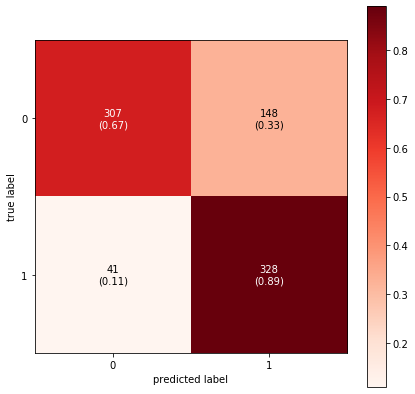

In [898]:
y_pred = model.predict_classes(X_test)

print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                  show_normed=True, cmap=plt.cm.Reds);
plt.show();

## Linear Regression with Rottentomatoes

### Features Only with Statsmodels OLS

In [4491]:
to_drop = rotten_df_cut.columns[:8]
to_drop = to_drop.append(rotten_df_cut.columns[19:24])

In [4492]:
to_drop_2 = ['sentiment_compound', 'unique_words', 'X', 'JJ', 'NNP', 'DET',
             'semi_ratios', 'ADJ']

In [4493]:
predictors_1 = rotten_df_cut[rotten_df_cut.columns[8:19]]
predictors_2 = rotten_df_cut[rotten_df_cut.columns[24:41]]
predictors_3 = rotten_df_cut[rotten_df_cut.columns[41:50]]
predictors_all = rotten_df_cut.copy()
predictors_all.drop(to_drop, axis=1, inplace=True)
predictors_all['category'] = rotten_df_cut.category
# predictors_all.drop(to_drop_2, axis=1,inplace=True)

In [4494]:
X_train, X_test, y_train, y_test = train_test_split(predictors_all,
                                                    rotten_df_cut.RottenScores,
                                                    test_size=.3)

In [4495]:
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

In [4496]:
temp = X_train_df.category
temp2 = X_test_df.category

In [4497]:
X_train_df = X_train_df.drop(['category'], axis=1)
X_test_df = X_test_df.drop(['category'], axis=1)

In [4498]:
scaler = StandardScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train_df), 
                          columns = X_train_df.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test_df), 
                            columns=X_test_df.columns)

In [4499]:
scaled_y_train = scaler.fit_transform(np.array(y_train).reshape(-1,1))
scaled_y_test = scaler.transform(np.array(y_test).reshape(-1,1))
scaled_y_train = pd.Series(scaled_y_train.reshape(-1,), name='RottenScores')
scaled_y_test = pd.Series(scaled_y_test.reshape(-1,), name='RottenScores')

In [4500]:
scaled_X_train['category'] = temp
scaled_X_test['category'] = temp2

In [4501]:
scaled_X_train.fillna(0, inplace=True)
scaled_X_test.fillna(0, inplace=True)

In [4502]:
def test(x):
    if x == 0:
        return math.log((X + 1) / 100)
    else:
        return math.log(x / 100)

In [4503]:
formula = 'RottenScores~' + '+'.join(scaled_X_train.columns)
formula += '+C(category)'

In [4504]:
data = scaled_X_train.merge(y_train, left_index=True, right_index=True)
model_1 = ols(formula=formula, data=data).fit()

In [4505]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           RottenScores   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.424
Date:                Thu, 05 Mar 2020   Prob (F-statistic):             0.0393
Time:                        07:29:36   Log-Likelihood:                -3281.7
No. Observations:                 753   AIC:                             6653.
Df Residuals:                     708   BIC:                             6861.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             30.1290      2.251     13.385      0.000      25.710      34.548
C(category)[T.1.0]     3.2484      2.908      1.117      0.264      -2.462       8.959
C(category)[T.2.0]     2.4525      2.245      1.092      0.275      -1.955       6.860
C(category)[T.3.0]     6.2098      3.793      1.637      0.102      -1.237      13.656
C(category)[T.4.0]     0.9103      1.970      0.462      0.644      -2.956       4.777
C(category)[T.5.0]    -3.2448      5.894     -0.551      0.582     -14.816       8.326
C(category)[T.6.0]    -3.1255      2.357     -1.326      0.185      -7.753       1.502
C(category)[T.7.0]    -4.6857      3.050     -1.536      0.125     -10.673       1.302
C(category)[T.8.0]     6.1429      6.028      1.019      0.309      -5.692      17.978
C(category)[T.9.0]    -1.2369      3.061     -0.404      0.686      -7.247       4.773
sentiment_negative    -3.8644     57.803     -0.067      0.947    -117.349     109.620
sentiment_neutral     -6.7478     84.382     -0.080      0.936    -172.417     158.921
sentiment_positive    -6.5260     72.797     -0.090      0.929    -149.450     136.398
sentiment_compound     0.3310      1.028      0.322      0.748      -1.687       2.349
word_count            19.2751      8.321      2.317      0.021       2.939      35.611
unique_words         -19.5100      8.360     -2.334      0.020     -35.924      -3.096
colon_ratios           1.4256      1.377      1.035      0.301      -1.278       4.129
semi_ratios            2.3556      2.029      1.161      0.246      -1.629       6.340
comma_ratios           0.9681      1.024      0.945      0.345      -1.043       2.979
ellipsis_ratios        0.1745      0.789      0.221      0.825      -1.374       1.723
SentenceLength         0.0490      1.751      0.028      0.978      -3.388       3.486
PROPN                 19.0611     22.876      0.833      0.405     -25.852      63.974
PUNCT                  4.9317      1.976      2.496      0.013       1.053       8.811
SYM                    0.0240      0.693      0.035      0.972      -1.337       1.385
VERB                   1.5663      1.849      0.847      0.397      -2.065       5.197
X                     -0.1212      0.782     -0.155      0.877      -1.657       1.414
SPACE                 -0.5037      0.741     -0.680      0.497      -1.959       0.952
ADJ                   -1.6731      5.947     -0.281      0.779     -13.349      10.002
ADP                   -0.7631      1.665     -0.458      0.647      -4.031       2.505
ADV                    0.1856      1.203      0.154      0.877      -2.176       2.547
AUX                   -0.8680      0.939     -0.925      0.355      -2.711       0.975
CCONJ                 -0.1315      0.557     -0.236      0.813      -1.224       0.961
DET                    2.5216      2.4

In [4506]:
y_hat_train = model_1.predict(pd.DataFrame(scaled_X_train))
y_hat_test = model_1.predict(pd.DataFrame(scaled_X_test))

In [4507]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [4508]:
train_residuals = y_hat_train - list(y_train)
test_residuals = y_hat_test - list(y_test)

In [4509]:
high_scores = [score for score in test_residuals if abs(score) >=50]
low_scores = [score for score in test_residuals if abs(score) <50]

In [4510]:
print(len(high_scores))
print(len(low_scores))

86
373


In [4511]:
(len(low_scores) - len(high_scores)) / len(low_scores)

0.7694369973190348

In [4512]:
sum(abs(test_residuals)) / len(test_residuals)

28.66299805395955

In [4513]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 251.85853749618357
Test Mean Squarred Error: 160.61961976674039


In [4514]:
print('R-sq score:', r2_score(y_test,y_hat_test))

R-sq score: -0.3625104828704757


In [4515]:
y_pred = model_1.predict(scaled_X_test)

In [4516]:
actual_v_predicted = X_test.copy()

In [4517]:
pred_scores = list(y_pred)

In [4518]:
actual_v_predicted['PredictedScores'] = pred_scores

In [4519]:
to_merge = rotten_df_cut[['Titles', 'RottenScores']]

In [4520]:
actual_v_predicted = actual_v_predicted.merge(to_merge, left_index=True,
                                              right_index=True)

In [4521]:
actual_v_predicted = actual_v_predicted[['Titles','RottenScores',
                                         'PredictedScores']]

In [4522]:
actual_v_predicted['PredictedScores'] = actual_v_predicted.PredictedScores.\
    apply(lambda x: int(x))

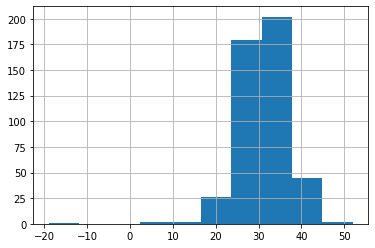

In [4523]:
actual_v_predicted.PredictedScores.hist()

In [4336]:
actual_v_predicted

Titles  RottenScores  PredictedScores
1124                      the_rachel_divide            71               28
103           im_in_love_with_a_church_girl             5               36
359                        sgt_will_gardner            21               37
30               mortal_kombat_annihilation             1               42
819                            the_humbling            51               37
1491             mission_impossible_fallout            97               39
127                                survivor             7               38
1063                                 lizzie            66               39
1257                         instant_family            80               38
1099                                 aniara            69               39
1328       the_miseducation_of_cameron_post            85               38
1265                                 quincy            81               37
729                             like_father            45               40
751                               curvature            46               39
122                   billionaire_boys_club             6               39
207                                   josie            12               35
505                          monster_trucks            31               37
441                            night_school            26               34
691                               tall_girl            43               32
680                                  madame            42               43
772                                  the_33            48               41
163                               stonewall             9               39
1264                              unlovable            81               36
208                      sword_of_vengeance            12               28
1065                        knives_and_skin            66               39
966                     mary_queen_of_scots            61               33
313                               wish_upon            18               18
683                  ricky_gervais_humanity            42               33
58                      happily_never_after             3               38
501                                  mojave            31               34
917                        the_hippopotamus            57               36
424                          the_benefactor            26               36
397                                  solace            24               38
42                    getting_even_with_dad             2               36
1034                             anthropoid            65               39
875                       swimming_with_men            54               35
116                     tomorrow_youre_gone             6               40
646                               hell_fest            40               44
944                              candy_corn            59               41
89                            jacobs_ladder             4               37
609                        waiting_for_anya            37               40
841                  magic_in_the_moonlight            51               26
948                       bohemian_rhapsody            59               38
922                           close_enemies            57               42
1313              the_land_of_steady_habits            84               36
59                                  6_souls             3               43
1404                             uncut_gems            91               39
1018                               the_wave            64               42
1422                              premature            92               34
155                              dont_sleep             8               36
901               the_house_that_jack_built            56               38
45                               feardotcom             2               43
896                                  my_son            56     

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



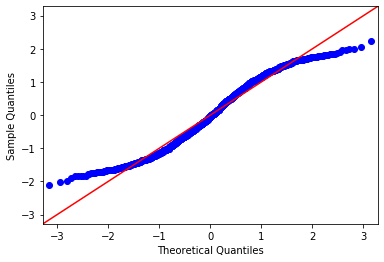

In [4488]:
residuals = model_1.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

### TFIDF with Statsmodels OLS

In [2265]:
# re_indexed = rotten_df_cut.set_index('Titles')

In [4343]:
X_train, X_test, y_train, y_test = train_test_split(rotten_df_cut.NoStop,
                                                    rotten_df_cut.RottenScores, test_size=.3,
                                                    random_state=42)

In [4344]:
tfidf = TfidfVectorizer(max_features=1500, max_df=.95, min_df=.1, 
                        ngram_range=(1,2))
word_predictors = tfidf.fit_transform(X_train)
word_test = tfidf.transform(X_test)

In [4345]:
predictors_spf = pd.SparseDataFrame(word_predictors, 
                                   columns=tfidf.get_feature_names())

In [4346]:
word_test_spf = pd.SparseDataFrame(word_test,
                                   columns=tfidf.get_feature_names())

In [4347]:
predictors_df = pd.DataFrame(predictors_spf,
                             columns=tfidf.get_feature_names())

In [4348]:
word_test_df = pd.DataFrame(word_test_spf, columns=tfidf.get_feature_names())

In [4349]:
to_drop = ['and','not','else','try','with','for','break','finally','while',
           'assert','continue','except','pass','raise','yield','raise',
           'return','from','or','if','in','is','class']
drop = []
for column in predictors_df.columns:
    if column in to_drop:
        drop.append(column)
    try:
        if int(column) > -1:
            drop.append(column)
    except:
        pass

In [4350]:
predictors_df.drop(drop, axis=1, inplace=True)
word_test_df.drop(drop, axis=1, inplace=True)

In [4351]:
predictors_df.fillna(0, inplace=True)
word_test_df.fillna(0, inplace=True)

In [4352]:
for column in tqdm(predictors_df.columns):
    if column.find(' ') > -1:
        rep = column.replace(' ', '_')
        predictors_df.rename(columns={column: rep}, inplace=True)
        word_test_df.rename(columns={column: rep}, inplace=True)

100%|██████████| 1466/1466 [01:50<00:00, 13.31it/s]


In [4353]:
target = rotten_df_cut.RottenScores
formula = "RottenScores~" + "+".join(predictors_df.columns)

In [4354]:
data = predictors_df.merge(y_train, left_index=True, right_index=True)

model_2 = ols(formula=formula, data=data).fit()

In [4355]:
model_2.rsquared

0.998199640844065

In [4356]:
y_pred = model_2.predict(word_test_df)

In [4357]:
actual_v_predicted = X_test.to_frame()

In [4358]:
pred_scores = list(y_pred)

In [4359]:
actual_v_predicted['PredictedScores'] = pred_scores

In [4360]:
to_merge = rotten_df_cut[['Titles', 'RottenScores']]

In [4361]:
actual_v_predicted = actual_v_predicted.merge(to_merge, left_index=True,
                                              right_index=True)

In [4362]:
actual_v_predicted = actual_v_predicted[['Titles','RottenScores',
                                         'PredictedScores']]

In [4363]:
actual_v_predicted['PredictedScores'] = actual_v_predicted.PredictedScores.\
    apply(lambda x: int(x))

In [4364]:
actual_v_predicted

Titles  RottenScores  \
1346                                          pavarotti            86   
76                      big_mommas_like_father_like_son             4   
1010                                           dead_ant            63   
660                                         the_package            41   
1133                                          snapshots            71   
982                                                edie            61   
1456                                    becoming_astrid            95   
1497                                            mcqueen            98   
1498                                       the_big_sick            98   
1190                                    swinging_safari            76   
1512                                               kedi            98   
628                                      justice_league            39   
394                                            rememory            24   
1479                                             border            96   
514                                         the_chamber            32   
626                                           nostalgia            39   
1114                                         horse_girl            70   
30                           mortal_kombat_annihilation             1   
49                                    battlefield_earth             2   
240                                            man_down            14   
429                                    rambo_last_blood            26   
351                                         i_hate_kids            21   
124                                            reprisal             7   
551                                   welcome_to_marwen            34   
1492                                             maiden            97   
70                                        vampires_suck             3   
1110                                    triple_frontier            70   
1032                                              siren            65   
1089                                           oceans_8            68   
1489                                               coco            97   
566                                         blair_witch            35   
342                                   the_book_of_henry            21   
1521                      invader_zim_enter_the_florpus            99   
932                                        charlie_says            58   
817                                       the_interview            51   
661                                          the_valley            41   
1080                                        the_journey            68   
1344                                           depraved            86   
493                                        loving_pablo            30   
481                                            red_joan            29   
1406                                    maria_by_callas            91   
943                                    operation_finale            59   
1310                                      the_vanishing            84   
571                                    state_like_sleep            35   
352                                                 222            21   
261                                         the_fanatic            15   
59                                              6_souls             3   
1392                                        gloria_bell            90   
1068                              zombieland_double_tap            67   
1276                     pope_francis_a_man_of_his_word            81   
259                                           show_dogs            15   
371                                    rim_of_the_world            22   
297                                               chips            18   
324                                  beneath_the_leaves            19   
306                      the_posse

In [4365]:
type(word_predictors)

scipy.sparse.csr.csr_matrix

In [4369]:
y_hat_train = model_2.predict(predictors_df)
y_hat_test = model_2.predict(word_test_df)

In [4370]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [4371]:
train_residuals = y_hat_train - list(y_train)
test_residuals = y_hat_test - list(y_test)

In [4372]:
high_scores = [score for score in test_residuals if abs(score) >=50]
low_scores = [score for score in test_residuals if abs(score) <50]

In [4373]:
print(len(high_scores))
print(len(low_scores))

143
316


In [4374]:
(len(low_scores) - len(high_scores)) / len(low_scores)

0.5474683544303798

In [4375]:
sum(abs(test_residuals)) / len(test_residuals)

39.36998055134432

In [4376]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 0.4943820224719101
Test Mean Squarred Error: 380.90713412610654


In [4377]:
print('R-sq score:', r2_score(y_test,y_hat_test))

R-sq score: -1.686241663543493


In [4378]:
y_pred = model_1.predict(scaled_X_test)

In [4393]:
actual_v_predicted = X_test.copy()

In [4403]:
type(pred_scores)

list

In [4413]:
pred_scores = pd.Series(pred_scores, name='PredictedScores')

In [4420]:
X_test.head()

1346     brazil. night before, luciano sang 200,000 pe...
76       (singing) yeah it's classic, baby i've world,...
1010     1 people peyote generations open mind explore...
660      okay, now... it's time bowling. right. come o...
1133     answers phone! drives nuts. you're driving nu...
Name: NoStop, dtype: object

In [4414]:
actual_v_predicted = pd.concat([y_test, pred_scores], axis=1, )

In [4390]:
actual_v_predicted = to_merge.merge(actual_v_predicted, left_index=True,
                                              right_index=True)

In [4424]:
list(zip(list(y_test), list(pred_scores)))

[(86, 28.8591072011191),
 (4, 36.420795106391665),
 (63, 37.64527359420025),
 (41, 42.102741948619986),
 (71, 37.74330744729639),
 (61, 39.44327805482685),
 (95, 38.74856629717807),
 (98, 39.809333404762185),
 (98, 38.28485340381218),
 (76, 39.310292583703244),
 (98, 38.417577381879795),
 (39, 37.2824216544394),
 (24, 40.98950121720986),
 (96, 39.86406969834647),
 (32, 39.15212028486512),
 (39, 35.408788197271434),
 (70, 37.521331563176616),
 (1, 34.67365697011924),
 (2, 32.14693045821713),
 (14, 43.248527122408575),
 (26, 41.419118703461805),
 (21, 39.010345826492994),
 (7, 36.60069752878303),
 (34, 28.59136442291191),
 (97, 39.196953333455795),
 (3, 33.77773048782967),
 (70, 18.33390403211112),
 (65, 33.80051591761149),
 (68, 38.17635237781944),
 (97, 34.91943814742899),
 (35, 36.780347688121566),
 (21, 36.38935480250214),
 (99, 38.727490241308445),
 (58, 36.47936256090502),
 (51, 39.04328776471954),
 (41, 35.04215047971422),
 (68, 40.92134817397459),
 (86, 44.12763363365556),
 (30, 

### TFIDF with sklearn

In [2939]:
X_train, X_test, y_train, y_test = train_test_split(rotten_df_cut.NoStop,
                                                    target, test_size=.3,
                                                    random_state=42)

In [2940]:
tfidf = TfidfVectorizer(max_features=1000, max_df=.95, min_df=.1, 
                        ngram_range=(1,2))
word_predictors = tfidf.fit_transform(X_train)
word_test = tfidf.transform(X_test)

In [2941]:
predictors_spf = pd.SparseDataFrame(word_predictors, 
                                   columns=tfidf.get_feature_names(),
                                   default_fill_value=0)

In [2942]:
word_test_spf = pd.SparseDataFrame(word_test, 
                                   columns=tfidf.get_feature_names(),
                                   default_fill_value=0)

In [2943]:
X = predictors_spf
vif = [variance_inflation_factor(X.values, i) for i in tqdm(range(X.shape[1]))]
vif_list = sorted(list(zip(predictors_spf.columns, vif)), key=lambda x: x[1],
                  reverse=True)

100%|██████████| 1000/1000 [15:36<00:00,  1.27it/s]


In [2944]:
revised_list = [item[0] for item in vif_list if item[1] < 20]

In [2945]:
print('original: ', len(predictors_spf.columns))
print('remaining: ', len(revised_list))

original:  1000
remaining:  53


In [2946]:
predictors_spf = predictors_spf[revised_list]
word_test_spf = word_test_spf[revised_list]

In [2947]:
lr = LinearRegression()
model = lr.fit(predictors_spf, y_train)

In [2948]:
model.score(predictors_spf, y_train)

0.08725750913691699

In [2949]:
model.score(word_test_spf, y_test)

-0.055917588028620686

In [2950]:
y_hat_train = model.predict(predictors_spf)
y_hat_test = model.predict(word_test_spf)

In [2951]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [2952]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 754.845500332331
Test Mean Squarred Error: 885.3356431004476


In [2953]:
actual_v_predicted = X_test.to_frame()

In [2954]:
pred_scores = list(y_preds)

In [2955]:
actual_v_predicted['PredictedScores'] = pred_scores

In [2956]:
to_merge = rotten_df_cut[['Titles', 'RottenScores']]

In [2957]:
actual_v_predicted = actual_v_predicted.merge(to_merge, left_index=True,
                                              right_index=True)

In [2958]:
actual_v_predicted = actual_v_predicted[['Titles','RottenScores',
                                         'PredictedScores']]

In [2959]:
actual_v_predicted['PredictedScores'] = actual_v_predicted.PredictedScores.\
    progress_apply(lambda x: int(x))

In [2960]:
actual_v_predicted.PredictedScores.value_counts()

47     152
46      67
48      67
45      31
49      25
44      17
50      14
43      12
52       9
53       6
51       6
42       6
41       5
59       4
38       4
34       4
32       4
54       3
39       3
37       2
36       2
35       2
65       2
40       2
27       1
101      1
76       1
55       1
56       1
57       1
60       1
63       1
68       1
22       1
Name: PredictedScores, dtype: int64

In [2961]:
actual_v_predicted.head(30)

Titles  RottenScores  PredictedScores
1346                        pavarotti            86               53
76    big_mommas_like_father_like_son             4               46
1010                         dead_ant            63               52
660                       the_package            41               49
1133                        snapshots            71               46
982                              edie            61               47
1456                  becoming_astrid            95               48
1497                          mcqueen            98               48
1498                     the_big_sick            98               47
1190                  swinging_safari            76               47
1512                             kedi            98               47
628                    justice_league            39               47
394                          rememory            24               47
1479                           border            96               46
514                       the_chamber            32               47
626                         nostalgia            39               47
1114                       horse_girl            70               46
30         mortal_kombat_annihilation             1               47
49                  battlefield_earth             2               47
240                          man_down            14               48
429                  rambo_last_blood            26               46
351                       i_hate_kids            21               49
124                          reprisal             7               44
551                 welcome_to_marwen            34               46
1492                           maiden            97               49
70                      vampires_suck             3               48
1110                  triple_frontier            70               46
1032                            siren            65               47
1089                         oceans_8            68               46
1489                             coco            97               63

### TFIDF with Decision Tree Classifier

In [3087]:
# test = grid_search_c(rotten_df_cut.NoStop, target, DecisionTreeRegressor(), params)

In [3195]:
X_train, X_test, y_train, y_test = train_test_split(rotten_df_cut.NoStop,
                                                    target, test_size=.3,
                                                    random_state=42)

In [3196]:
tfidf = TfidfVectorizer(max_features=5000, max_df=.95, min_df=.1, 
                        ngram_range=(1,2))
word_predictors = tfidf.fit_transform(X_train)
word_test = tfidf.transform(X_test)

In [3197]:
predictors_spf = pd.SparseDataFrame(word_predictors, 
                                   columns=tfidf.get_feature_names(),
                                   default_fill_value=0)

In [3198]:
word_test_spf = pd.SparseDataFrame(word_test, 
                                   columns=tfidf.get_feature_names(),
                                   default_fill_value=0)

In [3199]:
params = {'max_depth': [0,1,2,5,10,15,20],
          'min_samples_split': [1,2,5,10],
          'min_samples_leaf': [1,2,5,10]
         }
          

In [3200]:
# search = GridSearchCV(DecisionTreeRegressor(), cv=3,
#                            return_train_score=True, verbose=10,
#                            scoring='r2', param_grid=params,
#                            n_jobs=-1)

# # Performs a grid search and generates the best parameter set.
# search.fit(predictors_spf, y_train)

In [3201]:
search.best_params_

{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [3202]:
model = DecisionTreeRegressor(random_state=42, max_depth=2, min_samples_leaf=50,
                              min_samples_split=50)
model.fit(predictors_spf, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=50, min_samples_split=50,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [3203]:
y_pred = model.predict(word_test_spf)
print('MSE score:', mse(y_test, y_pred))
print('R-sq score:', r2_score(y_test,y_pred))

MSE score: 810.2829962645452
R-sq score: 0.033595819050075915


In [3204]:
model.score(predictors_spf, y_train)

0.09468688157089733

In [3205]:
model.score(word_test_spf, y_test)

0.033595819050075915

In [3206]:
y_hat_train = model.predict(predictors_spf)
y_hat_test = model.predict(word_test_spf)

In [3207]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [3208]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 748.7013486047389
Test Mean Squarred Error: 810.2829962645452


In [3209]:
actual_v_predicted = X_test.to_frame()

In [3210]:
pred_scores = list(y_pred)

In [3211]:
actual_v_predicted['PredictedScores'] = pred_scores

In [3212]:
to_merge = rotten_df_cut[['Titles', 'RottenScores']]

In [3213]:
actual_v_predicted = actual_v_predicted.merge(to_merge, left_index=True,
                                              right_index=True)

In [3214]:
actual_v_predicted = actual_v_predicted[['Titles','RottenScores',
                                         'PredictedScores']]

In [3215]:
actual_v_predicted['PredictedScores'] = actual_v_predicted.PredictedScores.\
    apply(lambda x: int(x))

In [3216]:
actual_v_predicted.PredictedScores.value_counts()

47    308
34     87
71     42
44     22
Name: PredictedScores, dtype: int64

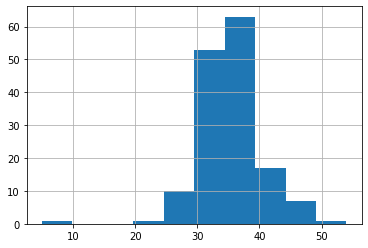

In [4490]:
actual_v_predicted.PredictedScores.hist()

In [3217]:
actual_v_predicted.head(30)

Titles  RottenScores  PredictedScores
1346                        pavarotti            86               44
76    big_mommas_like_father_like_son             4               47
1010                         dead_ant            63               47
660                       the_package            41               34
1133                        snapshots            71               47
982                              edie            61               47
1456                  becoming_astrid            95               34
1497                          mcqueen            98               71
1498                     the_big_sick            98               47
1190                  swinging_safari            76               47
1512                             kedi            98               71
628                    justice_league            39               47
394                          rememory            24               47
1479                           border            96               34
514                       the_chamber            32               47
626                         nostalgia            39               44
1114                       horse_girl            70               47
30         mortal_kombat_annihilation             1               34
49                  battlefield_earth             2               47
240                          man_down            14               47
429                  rambo_last_blood            26               71
351                       i_hate_kids            21               47
124                          reprisal             7               47
551                 welcome_to_marwen            34               34
1492                           maiden            97               71
70                      vampires_suck             3               34
1110                  triple_frontier            70               47
1032                            siren            65               47
1089                         oceans_8            68               47
1489                             coco            97               47

### TFIDF with XGBoost Regressor

I grid searched the hell out of this one, only to find that none of it mattered. So I removed the grid search function.

In [5310]:
X_train, X_test, y_train, y_test = train_test_split(rotten_df_cut.NoStop,
                                                    target, test_size=.3,
                                                    random_state=42)

In [5311]:
tfidf = TfidfVectorizer(max_features=5000, max_df=.9, min_df=.1, 
                        ngram_range=(1,2))
word_predictors = tfidf.fit_transform(X_train)
word_test = tfidf.transform(X_test)

In [5312]:
model = XGBRegressor(random_state=42, n_estimators=100, 
                     objective='reg:squarederror')
model.fit(word_predictors, y_train)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [5313]:
y_pred = model.predict(word_test)
print('MSE score:', mse(y_test, y_pred))
print('R-sq score:', r2_score(y_test,y_pred))

MSE score: 743.6977868338219
R-sq score: 0.1130103261789761


In [5314]:
model.score(word_predictors, y_train)

0.7954558705347395

In [5315]:
model.score(word_test, y_test)

0.1130103261789761

In [5316]:
y_hat_train = model.predict(word_predictors)
y_hat_test = model.predict(word_test)

In [5317]:
type(y_train)

pandas.core.series.Series

In [5318]:
train_residuals = y_hat_train - list(y_train)
test_residuals = y_hat_test - list(y_test)

In [5319]:
high_scores = [score for score in test_residuals if abs(score) >=50]
low_scores = [score for score in test_residuals if abs(score) <50]

In [5320]:
print(len(high_scores))
print(len(low_scores))

22
437


In [5321]:
(len(low_scores) - len(high_scores)) / len(low_scores)

0.9496567505720824

In [5322]:
count_low = len(abs(train_residuals) <= 50)

In [5323]:
print(count_high)
print(count_low)

1068
1068


In [5324]:
sum(abs(test_residuals)) / len(test_residuals)

22.875444088106843

In [5325]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 169.15966692889117
Test Mean Squarred Error: 743.6977868338219


In [5326]:
actual_v_predicted = X_test.to_frame()

In [5327]:
pred_scores = list(y_pred)

In [5328]:
actual_v_predicted['PredictedScores'] = pred_scores

In [5329]:
to_merge = rotten_df_cut[['Titles', 'RottenScores']]

In [5330]:
actual_v_predicted = actual_v_predicted.merge(to_merge, left_index=True,
                                              right_index=True)

In [5331]:
actual_v_predicted = actual_v_predicted[['Titles','RottenScores',
                                         'PredictedScores']]

In [5332]:
actual_v_predicted['PredictedScores'] = actual_v_predicted.PredictedScores.\
    apply(lambda x: int(x))

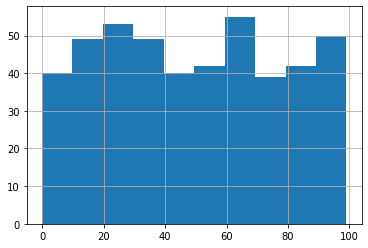

In [5333]:
actual_v_predicted.RottenScores.hist();

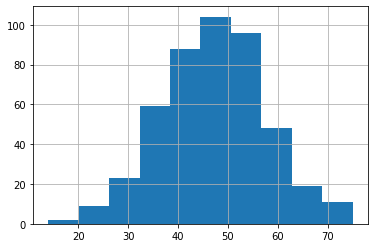

In [5334]:
actual_v_predicted.PredictedScores.hist();

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



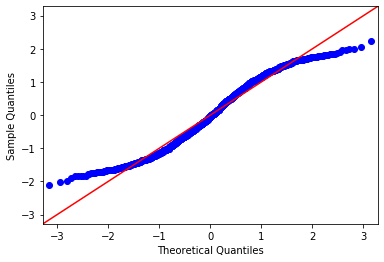

In [5335]:
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show();

In [5336]:
actual_v_predicted

Titles  RottenScores  \
1346                                          pavarotti            86   
76                      big_mommas_like_father_like_son             4   
1010                                           dead_ant            63   
660                                         the_package            41   
1133                                          snapshots            71   
982                                                edie            61   
1456                                    becoming_astrid            95   
1497                                            mcqueen            98   
1498                                       the_big_sick            98   
1190                                    swinging_safari            76   
1512                                               kedi            98   
628                                      justice_league            39   
394                                            rememory            24   
1479                                             border            96   
514                                         the_chamber            32   
626                                           nostalgia            39   
1114                                         horse_girl            70   
30                           mortal_kombat_annihilation             1   
49                                    battlefield_earth             2   
240                                            man_down            14   
429                                    rambo_last_blood            26   
351                                         i_hate_kids            21   
124                                            reprisal             7   
551                                   welcome_to_marwen            34   
1492                                             maiden            97   
70                                        vampires_suck             3   
1110                                    triple_frontier            70   
1032                                              siren            65   
1089                                           oceans_8            68   
1489                                               coco            97   
566                                         blair_witch            35   
342                                   the_book_of_henry            21   
1521                      invader_zim_enter_the_florpus            99   
932                                        charlie_says            58   
817                                       the_interview            51   
661                                          the_valley            41   
1080                                        the_journey            68   
1344                                           depraved            86   
493                                        loving_pablo            30   
481                                            red_joan            29   
1406                                    maria_by_callas            91   
943                                    operation_finale            59   
1310                                      the_vanishing            84   
571                                    state_like_sleep            35   
352                                                 222            21   
261                                         the_fanatic            15   
59                                              6_souls             3   
1392                                        gloria_bell            90   
1068                              zombieland_double_tap            67   
1276                     pope_francis_a_man_of_his_word            81   
259                                           show_dogs            15   
371                                    rim_of_the_world            22   
297                                               chips            18   
324                                  beneath_the_leaves            19   
306                      the_posse

# Conclusions